Revisi Project DS batch november 2022
Tema : classification, Customer Churn

In [1]:
import pandas as pd
pd.set_option("display.max_columns",None) # menampilkan seluruh kolom

#===== Numpy =====
import numpy as np

#===== visualisation ======
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#====== Stats =====
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

#====== Model ======
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier


#===== Evaluation ======
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             classification_report,
                             roc_curve)
from sklearn.metrics import ConfusionMatrixDisplay
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import validation_curve

#===== Function ======
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def create_stacked_bar_percent(df,column_name):
        
    # Get the percentage of default by each group
    default_by_group = pd.crosstab(index=df['default'],columns = df[column_name], normalize = 'columns')
    default_by_group = default_by_group[default_by_group.iloc[1].sort_values().index]
    
    # Round up to 2 decimal
    default_by_group = default_by_group.apply(lambda x: round(x,2))
    
    labels = default_by_group.columns
    list1 = default_by_group.iloc[0].to_list()
    list2 = default_by_group.iloc[1].to_list()
    
    list1_name = "Not Default"
    list2_name = "Default"
    title = f" %Default by {column_name}"
    xlabel = column_name
    ylabel = "Number of Default"
    
    fig, ax = plt.subplots(figsize=(8,8),dpi=100)
    bar_width = 0.5
    
    ax1 = ax.bar(labels,list1, bar_width, label = list1_name)
    ax2 = ax.bar(labels,list2, bar_width, bottom = list1, label = list2_name)

    ax.set_title(title, fontweight = "bold",fontsize=12)
    ax.set_xlabel(xlabel, fontweight = "bold",fontsize=12)
    ax.set_ylabel(ylabel, fontweight = "bold",fontsize=12)
    ax.legend(loc="upper right")
    
    plt.xticks(list(range(len(labels))), labels,rotation=90)
    plt.yticks(fontsize=12)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f"{h1:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f"{h2:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.show()

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

def missing_check(df):
  missing = df.isnull().sum()
  missing_per = round(missing/len(df),4)*100
  unique_val = df.nunique()
  type_data = df.dtypes
  df = pd.DataFrame({'Missing_values':missing,
                    'Percent of Missing (%)':missing_per,
                    'Numbers of Unique':unique_val,
                    'Data type':type_data}).sort_values("Percent of Missing (%)",ascending=False)
  return df

In [2]:
df = pd.read_excel(r'D:\01-FullStack Bangalore\00-FInal Project\00-Project\E Commerce Dataset.xlsx')

In [3]:
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [4]:
df.info()

#jumalah seluruh data 5630
#data missing di atas 40% akan di drop seluruhnya 
#data missing di bawah 15% akan di imputasi sesuai dengan imputasi yg cocok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [5]:
#cek data duplicated 
df.duplicated().sum()
#tidak ada data duplikat 

0

In [6]:
#membagi data num dan cat 

cat = ['PreferredLoginDevice','PreferredPaymentMode','Gender',
       'PreferedOrderCat','MaritalStatus']
num = ['CustomerID','Churn','Tenure','CityTier','WarehouseToHome',
       'HourSpendOnApp','NumberOfDeviceRegistered','SatisfactionScore',
       'NumberOfAddress','Complain','OrderAmountHikeFromlastYear','CouponUsed',
       'OrderCount','DaySinceLastOrder','CashbackAmount']

In [7]:
df[cat].describe()

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5630,5630,5630,5630,5630
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2765,2314,3384,2050,2986


In [8]:
df[num].describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


In [9]:
pd.set_option("display.max_rows",None)
missing_check(df)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
DaySinceLastOrder,307,5.45,22,float64
OrderAmountHikeFromlastYear,265,4.71,16,float64
Tenure,264,4.69,36,float64
OrderCount,258,4.58,16,float64
CouponUsed,256,4.55,17,float64
HourSpendOnApp,255,4.53,6,float64
WarehouseToHome,251,4.46,34,float64
CustomerID,0,0.00,5630,int64
MaritalStatus,0,0.00,3,object
Complain,0,0.00,2,int64


C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/3329158956.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, len(num)/3, i+1)
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/3329158956.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, len(num)/3, i+1)
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\

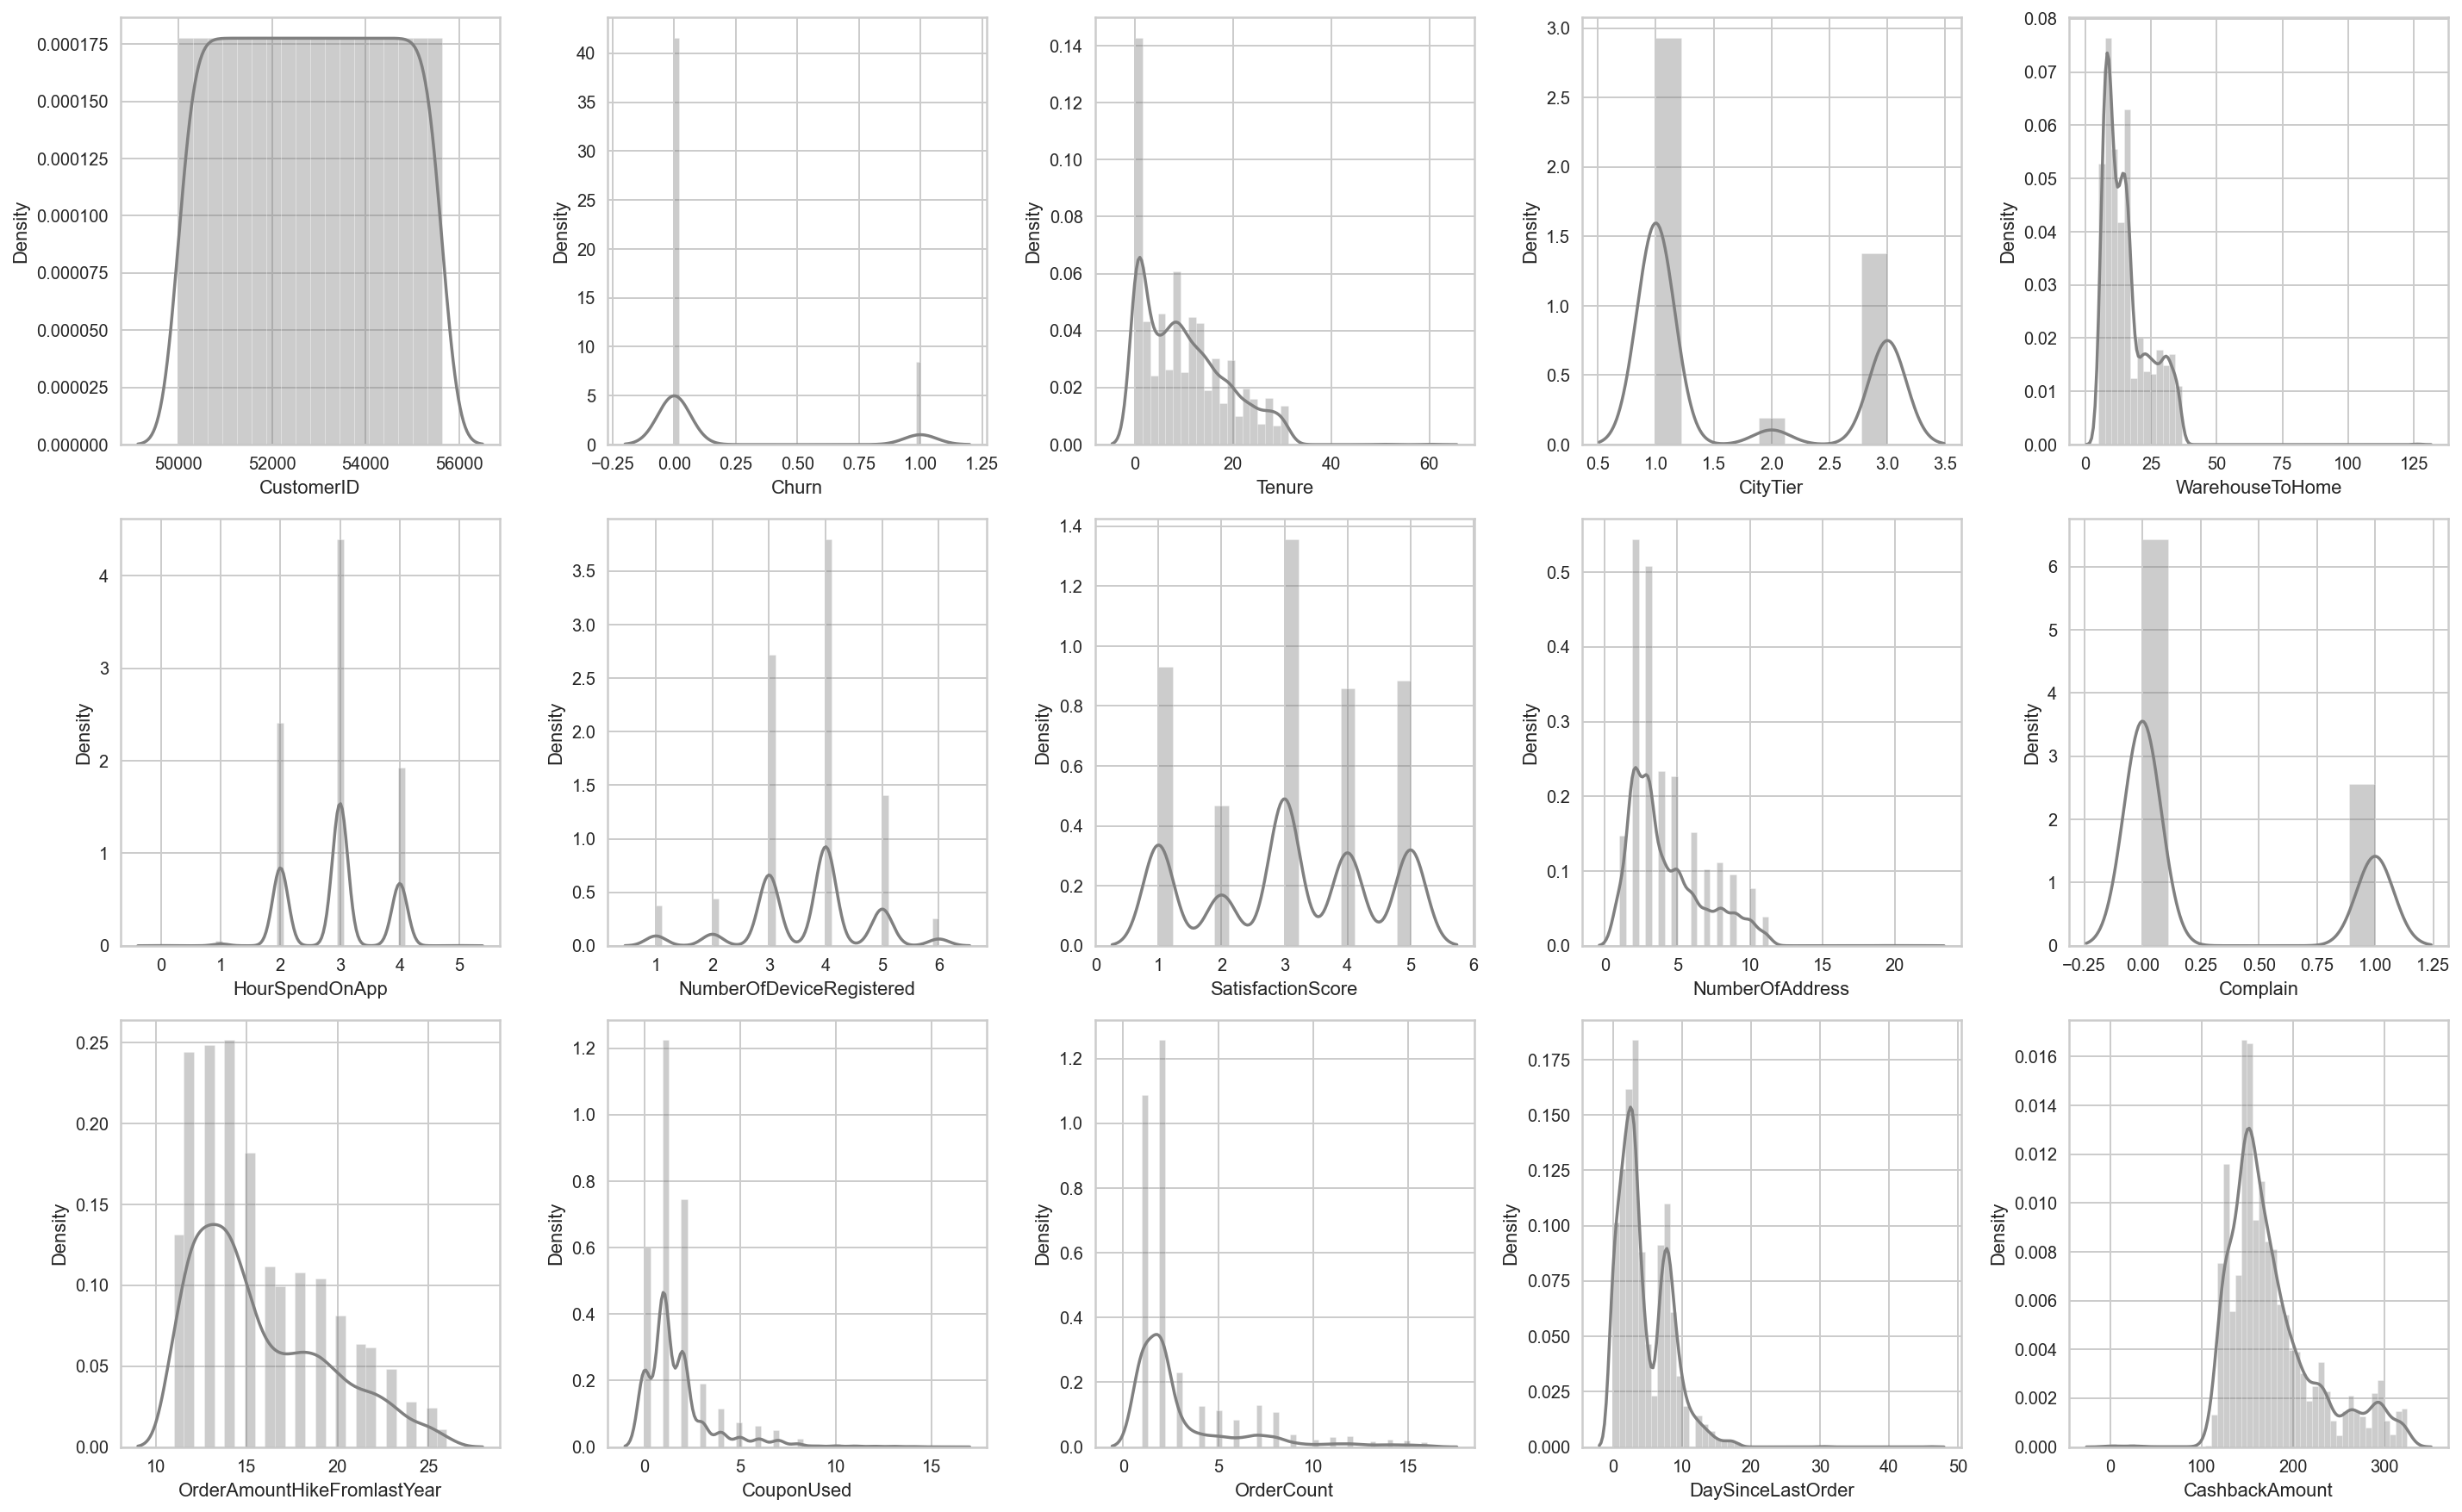

In [10]:
plt.figure(figsize=(20,20))
for i in range(0, len(num)):
    plt.subplot(5, len(num)/3, i+1)
    sns.distplot(df[num[i]], color='gray')
    plt.tight_layout()

In [11]:
#imputasi misiing value
df['DaySinceLastOrder'] = df['DaySinceLastOrder'].fillna(df['DaySinceLastOrder'].median())
df['OrderAmountHikeFromlastYear'] = df['OrderAmountHikeFromlastYear'].fillna(
    df['OrderAmountHikeFromlastYear'].median()
)
#Persentase kenaikan secara berurutan dari tahun lalu
df['Tenure']=df['Tenure'].fillna(df['Tenure'].median())
df['OrderCount']=df['OrderCount'].fillna(df['OrderCount'].median())
df['CouponUsed']=df['CouponUsed'].fillna(4)
df['HourSpendOnApp']=df['HourSpendOnApp'].fillna(df['HourSpendOnApp'].mean())
df['WarehouseToHome']=df['WarehouseToHome'].fillna(
    df['WarehouseToHome'].median()
)

In [12]:
#cek kembali missing value
missing_check(df)

#data sudah bersih 

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
CustomerID,0,0.0,5630,int64
Churn,0,0.0,2,int64
DaySinceLastOrder,0,0.0,22,float64
OrderCount,0,0.0,16,float64
CouponUsed,0,0.0,17,float64
OrderAmountHikeFromlastYear,0,0.0,16,float64
Complain,0,0.0,2,int64
NumberOfAddress,0,0.0,15,int64
MaritalStatus,0,0.0,3,object
SatisfactionScore,0,0.0,5,int64


C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/2825069079.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, len(num)/3, i+1)
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/2825069079.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specific

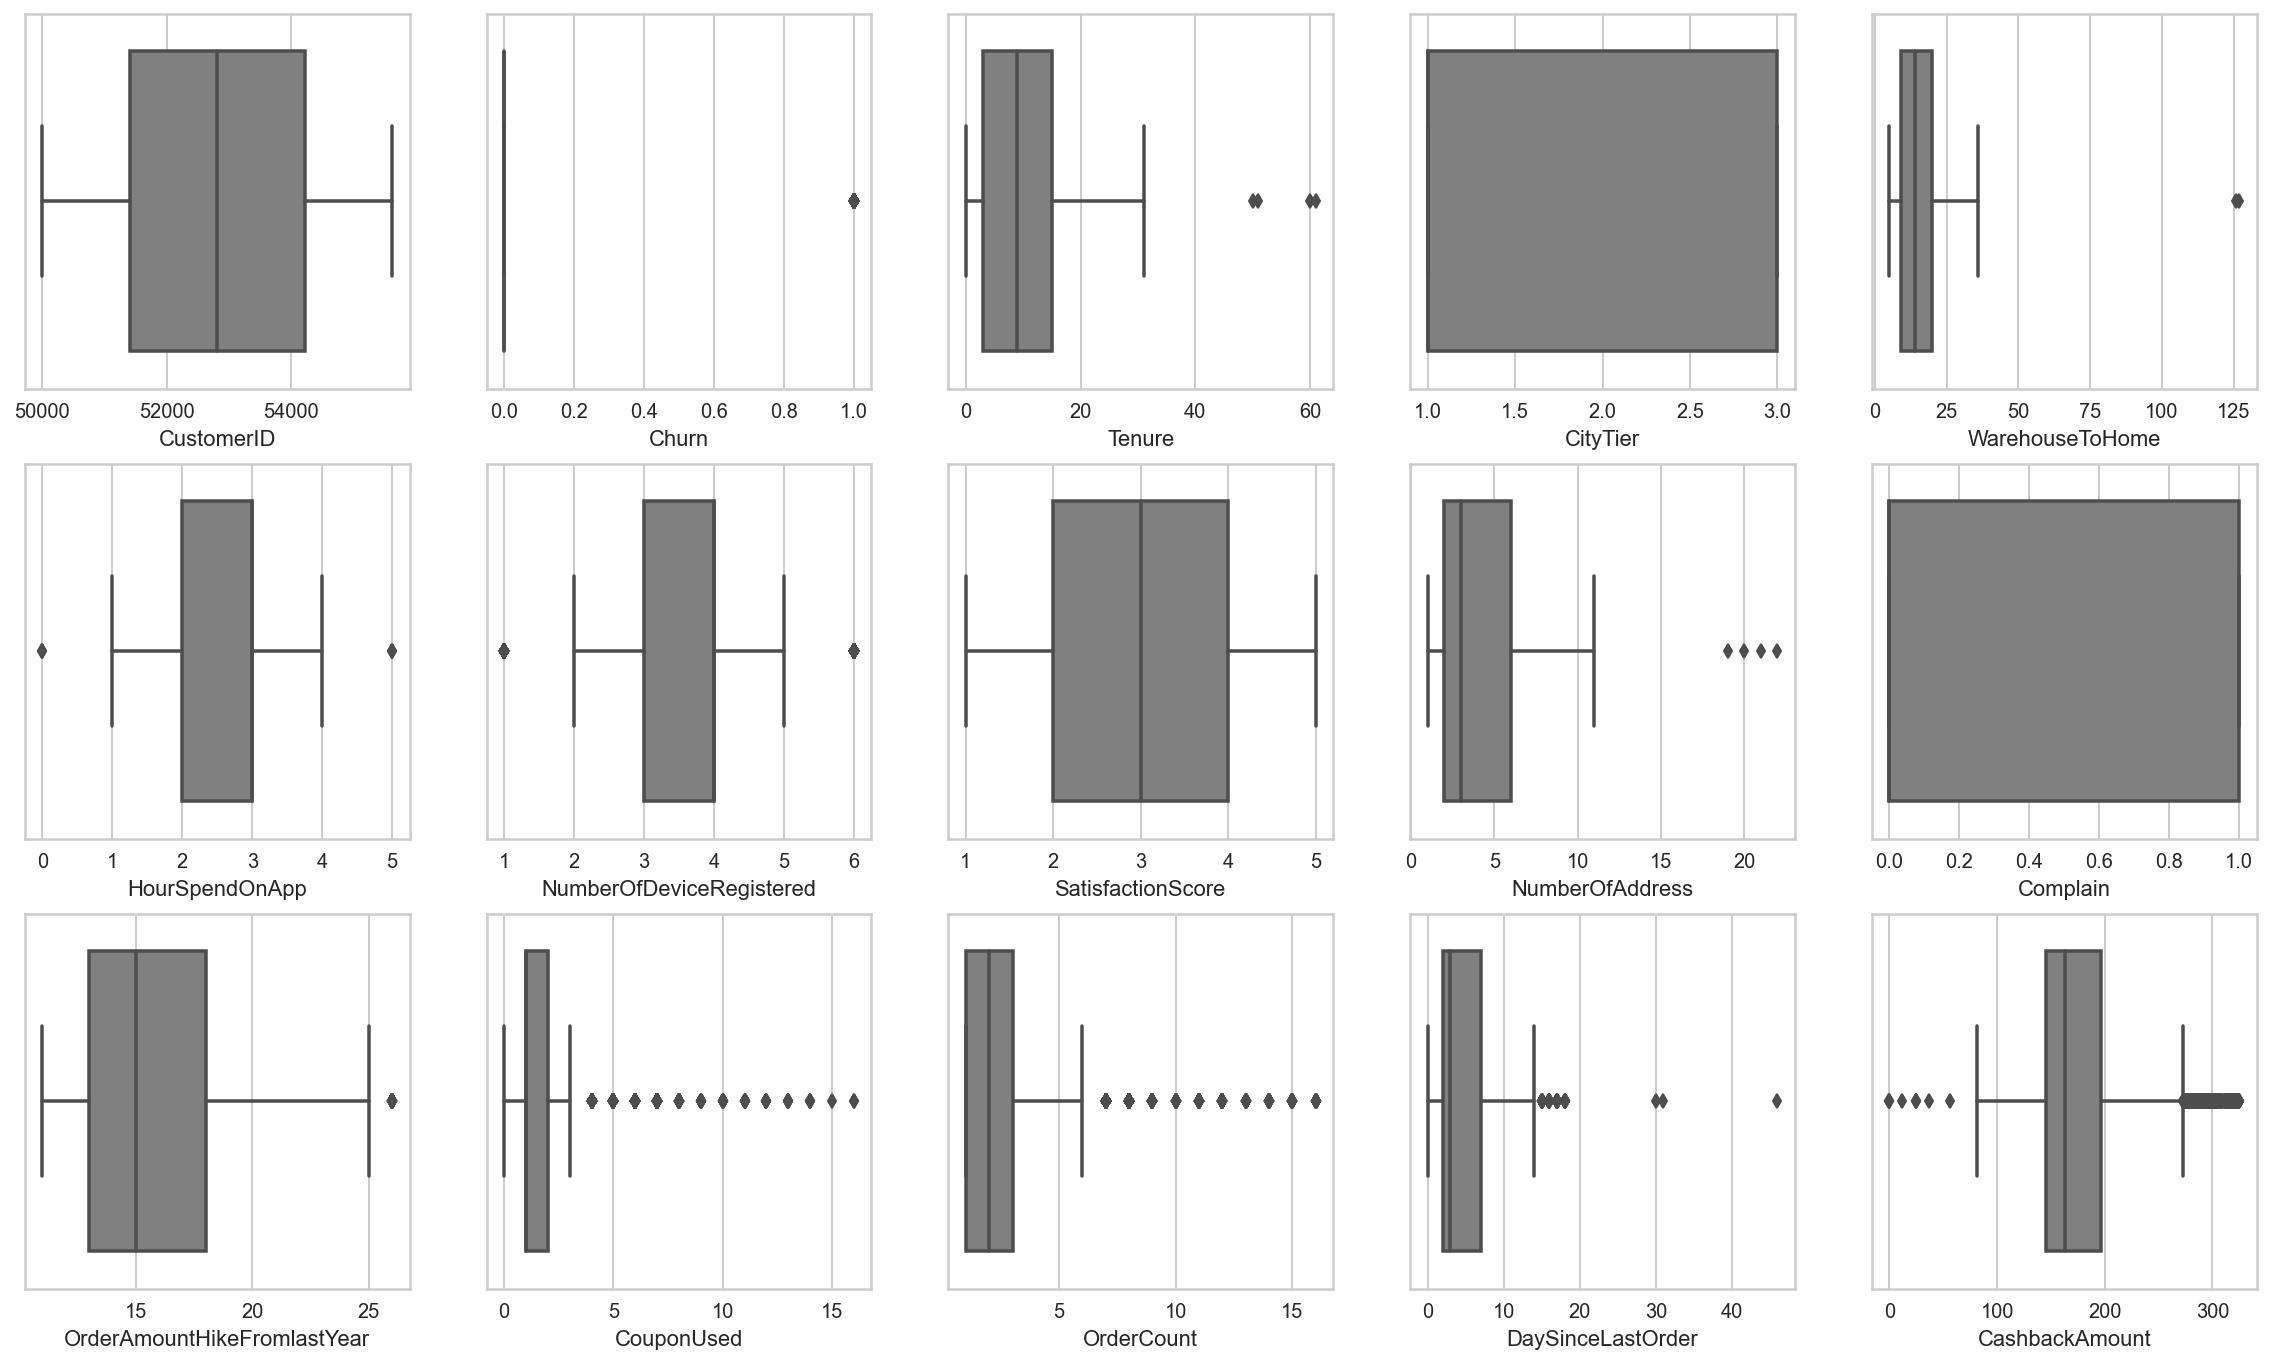

In [13]:
#cek outliers pada data numeric
plt.figure(figsize=(20,20))
for i in range(0, len(num)):
    plt.subplot(5, len(num)/3, i+1)
    sns.boxplot(df[num[i]],color='gray', orient='v')
    

C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/290037987.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(3,len(cat)/2, i+1)
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/290037987.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(3,len(cat)/2, i+1)
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pa

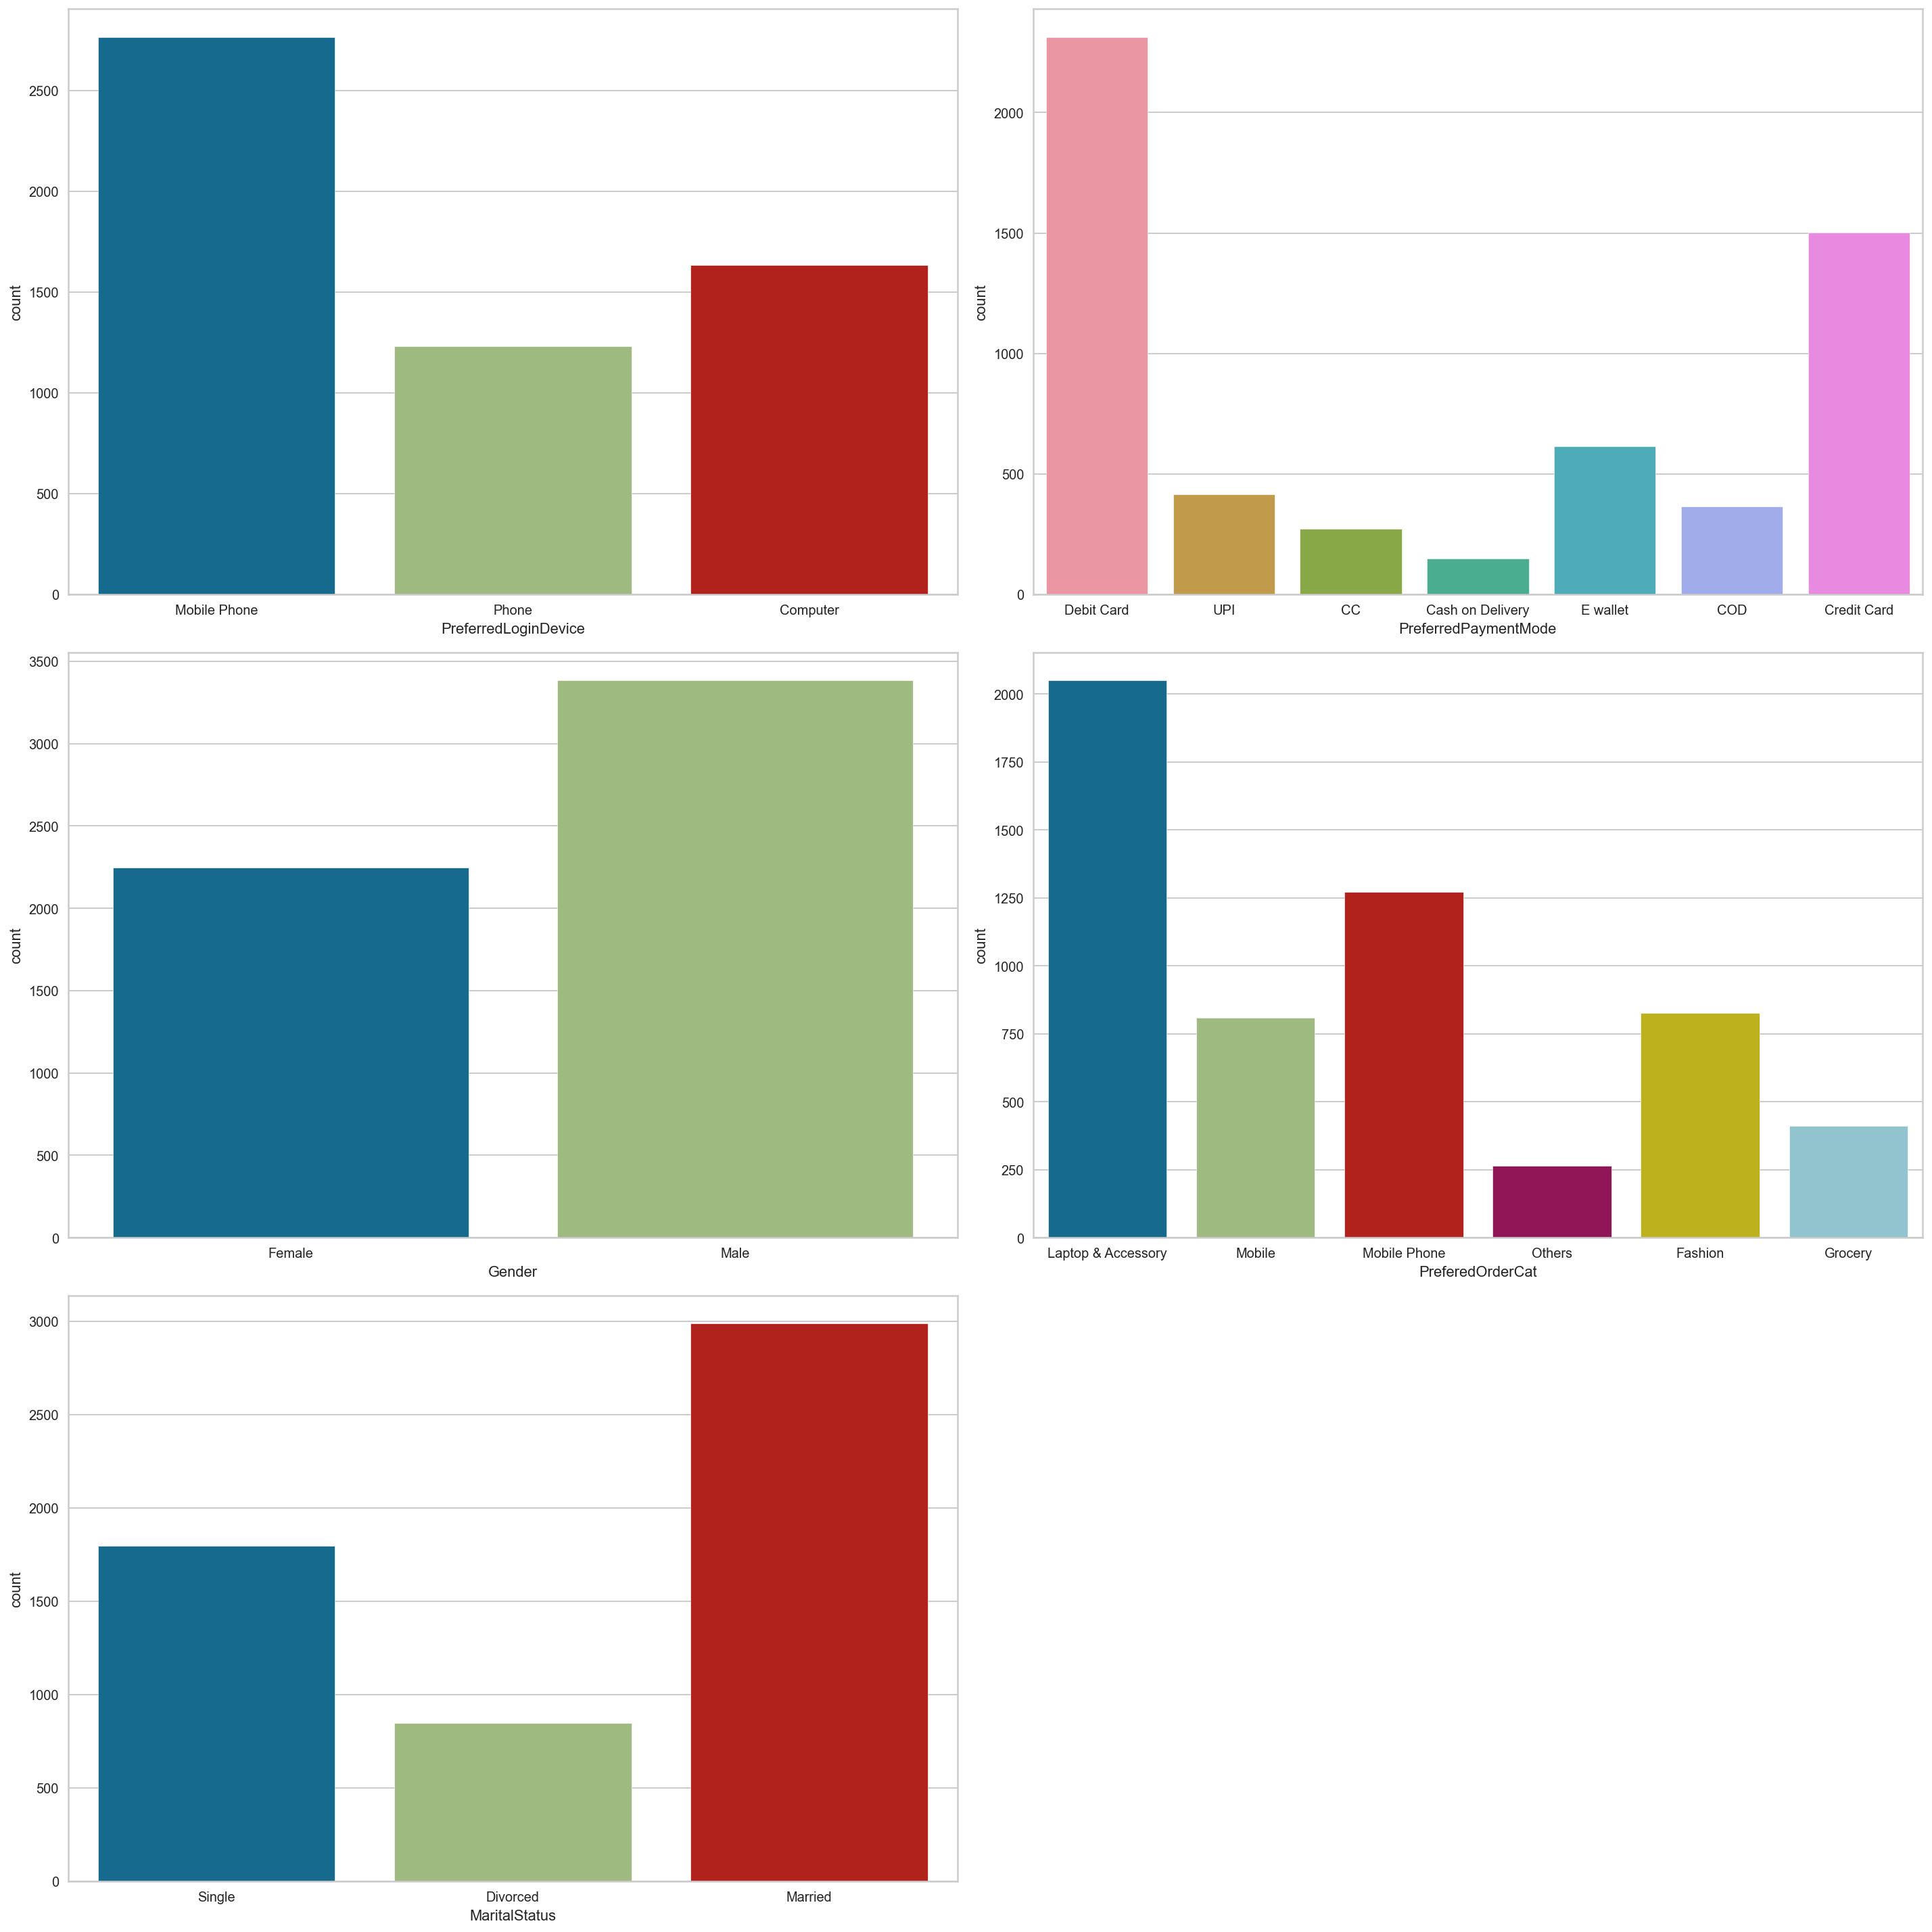

In [14]:
plt.figure(figsize=(20,20))
for i in range(0, len(cat)):
    plt.subplot(3,len(cat)/2, i+1)
    sns.countplot(df[cat[i]], orient='v')
    plt.tight_layout()

In [15]:
missing_check(df)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
CustomerID,0,0.0,5630,int64
Churn,0,0.0,2,int64
DaySinceLastOrder,0,0.0,22,float64
OrderCount,0,0.0,16,float64
CouponUsed,0,0.0,17,float64
OrderAmountHikeFromlastYear,0,0.0,16,float64
Complain,0,0.0,2,int64
NumberOfAddress,0,0.0,15,int64
MaritalStatus,0,0.0,3,object
SatisfactionScore,0,0.0,5,int64


<AxesSubplot:>

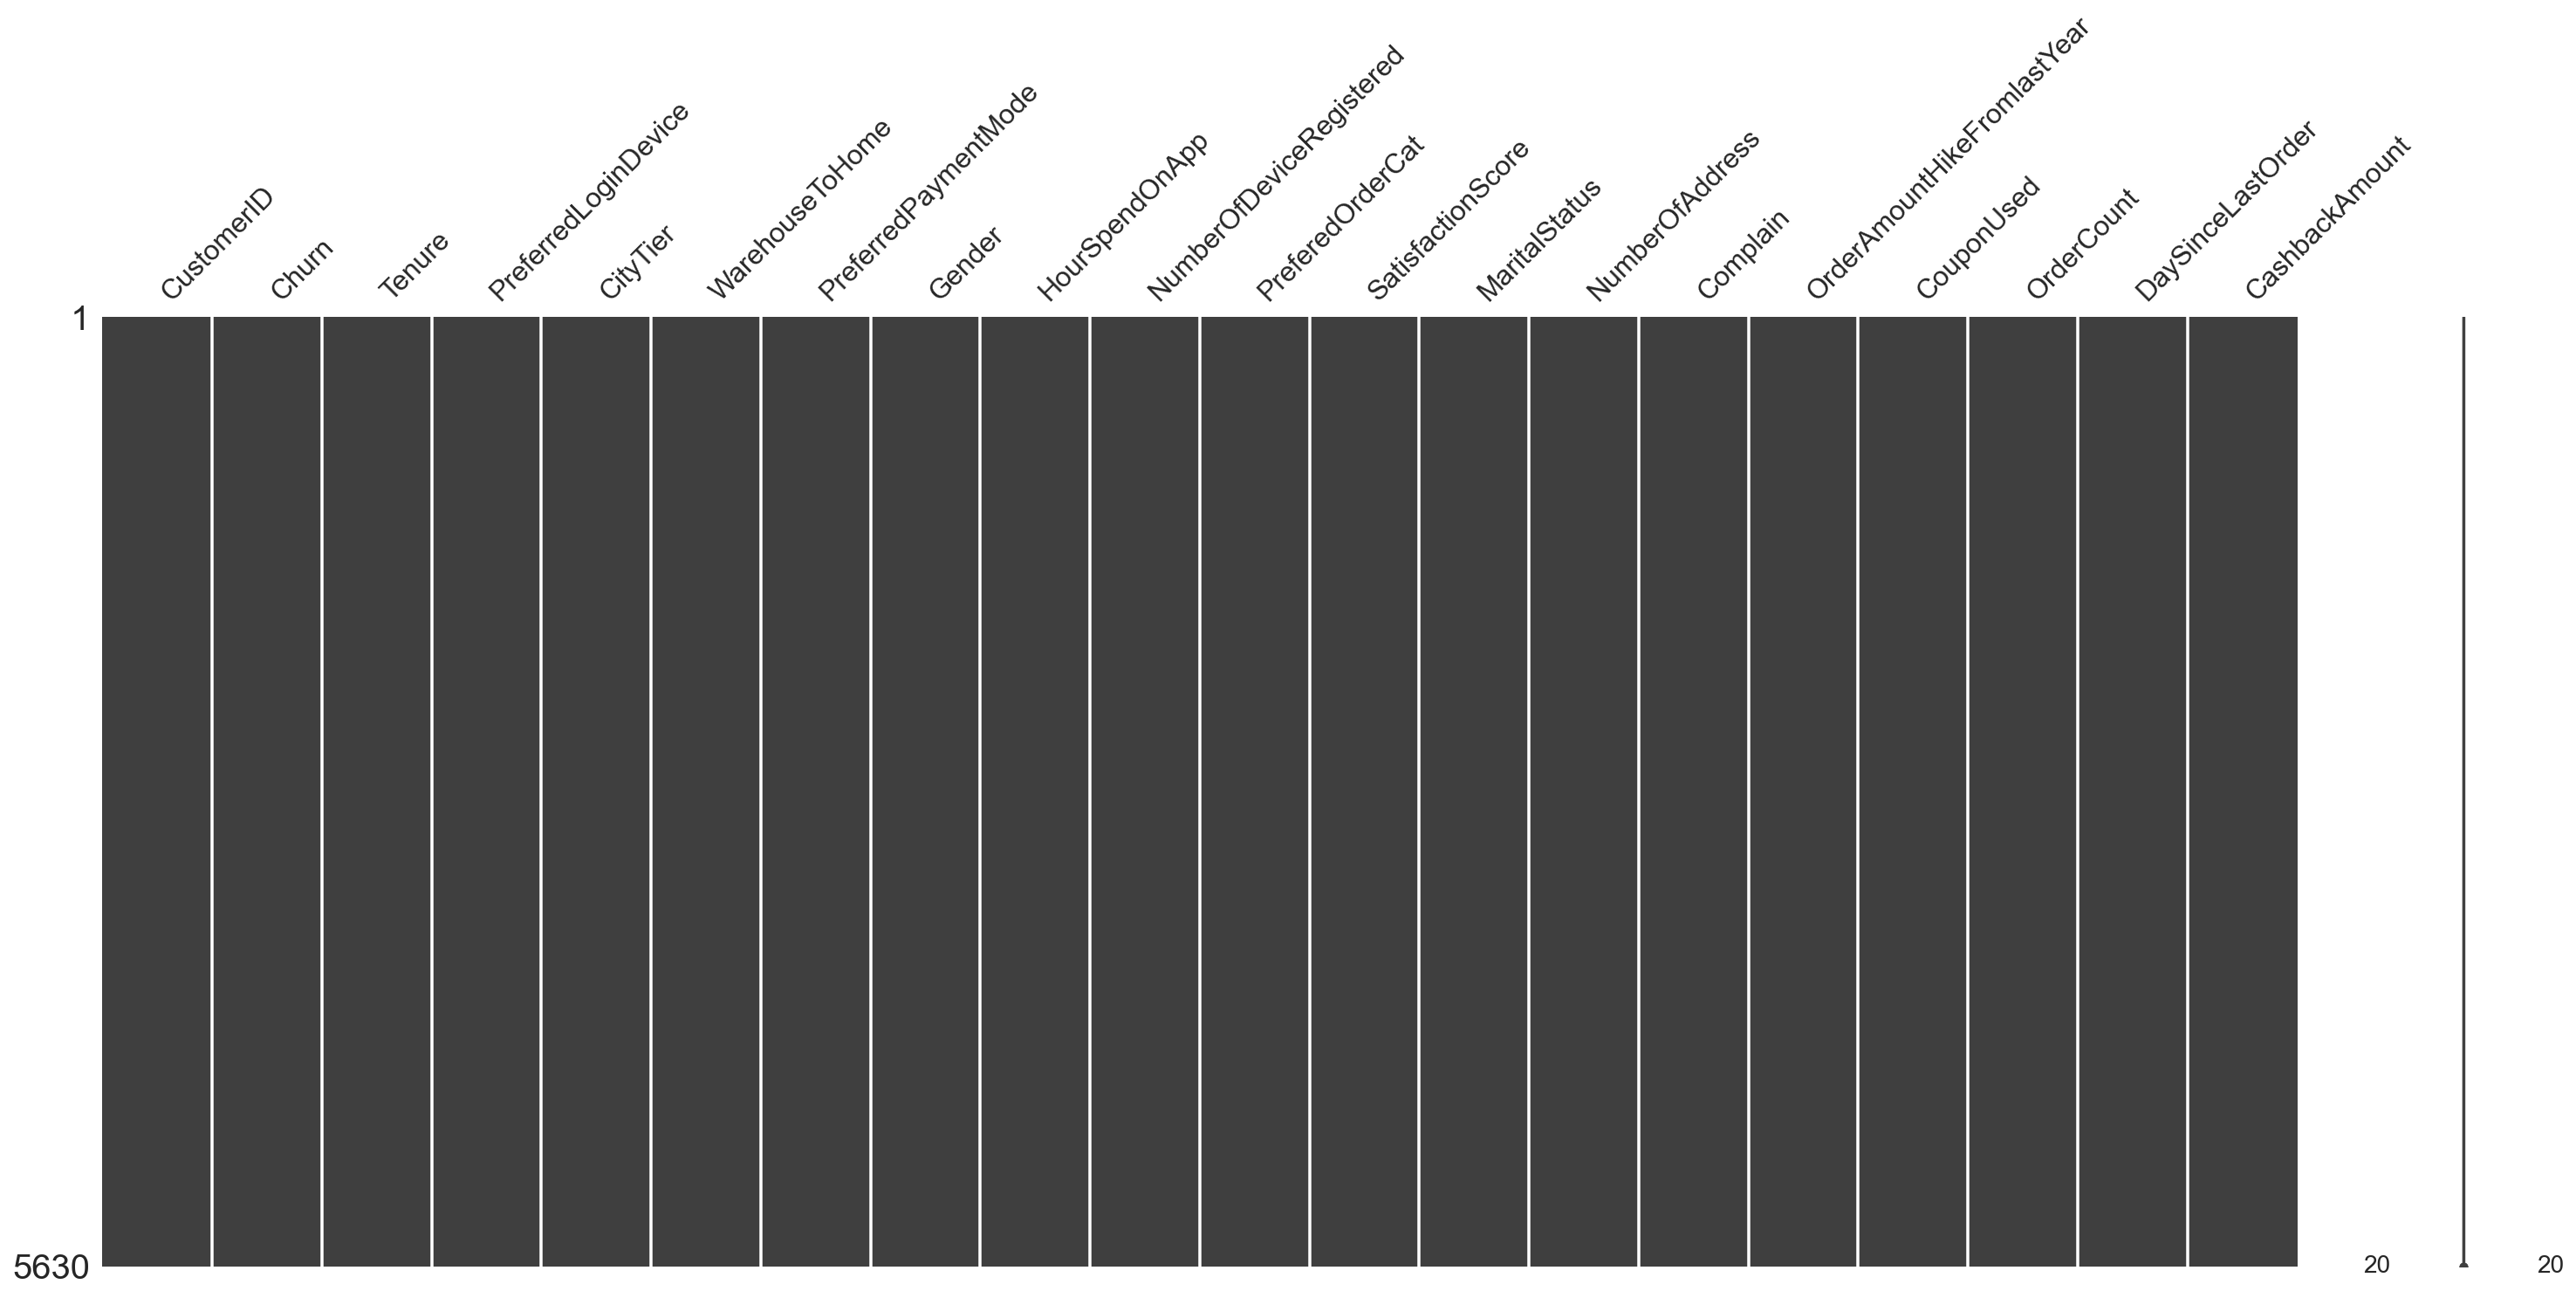

In [16]:
import missingno as msno
msno.matrix(df)

In [17]:
#drop kolom untuk model 
df = df.drop(['CustomerID',
              'NumberOfAddress',
              'NumberOfDeviceRegistered',
              'WarehouseToHome',
              'CityTier'],axis=1)
df = df.reset_index(drop=True)

In [18]:
df.columns

Index(['Churn', 'Tenure', 'PreferredLoginDevice', 'PreferredPaymentMode',
       'Gender', 'HourSpendOnApp', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [19]:
#cek misissing kembali 
missing_check(df)

,Missing_values,Percent of Missing (%),Numbers of Unique,Data type
Churn,0,0.0,2,int64
Tenure,0,0.0,36,float64
PreferredLoginDevice,0,0.0,3,object
PreferredPaymentMode,0,0.0,7,object
Gender,0,0.0,2,object
HourSpendOnApp,0,0.0,7,float64
PreferedOrderCat,0,0.0,6,object
SatisfactionScore,0,0.0,5,int64
MaritalStatus,0,0.0,3,object
Complain,0,0.0,2,int64


In [20]:
#target model adalah Customer yang akan churn 
df['Churn'].value_counts()

#0=tidak churn 
#1=churn

0    4682
1     948
Name: Churn, dtype: int64

([<matplotlib.patches.Wedge at 0x2d9ca3efaf0>,
 [Text(-0.9496473517375876, 0.555130531801113, 'Non_Churn'),
  Text(0.9496473517375879, -0.5551305318011128, 'Churn')],
 [Text(-0.5179894645841386, 0.3027984718915162, '83.2%'),
  Text(0.5179894645841387, -0.30279847189151604, '16.8%')])

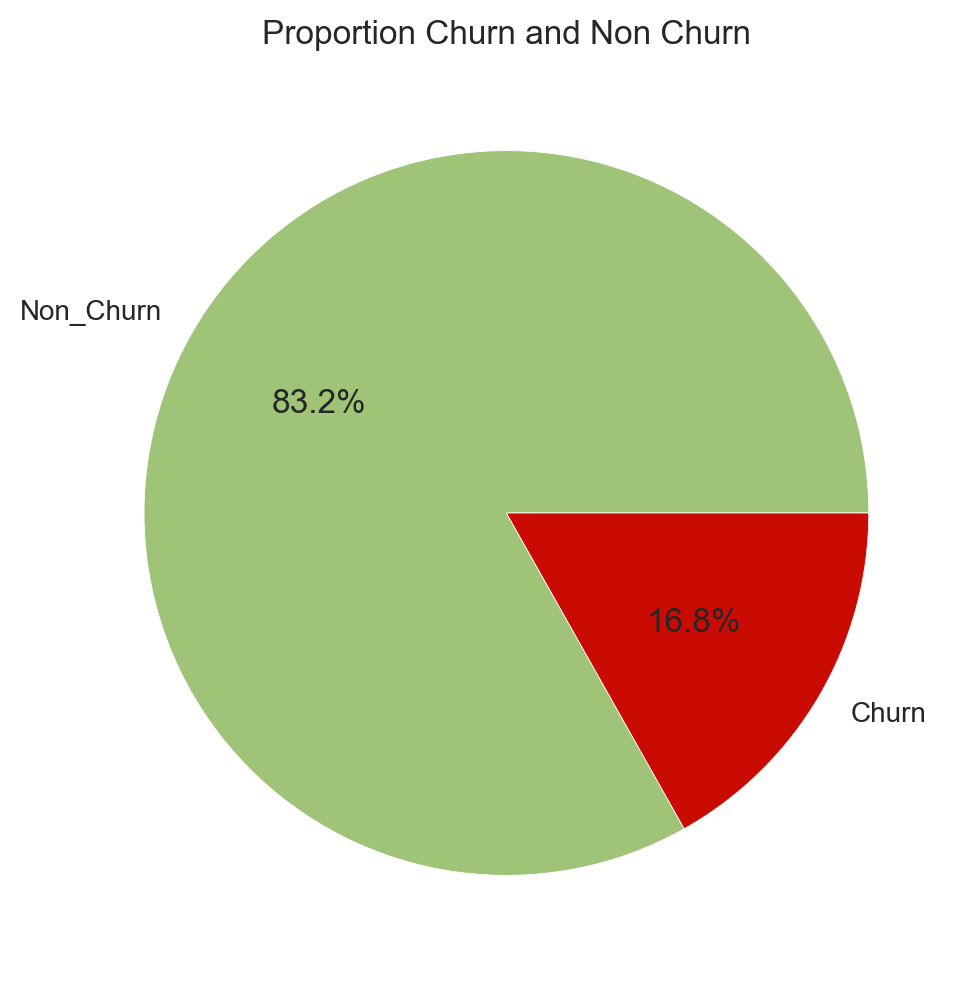

In [21]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("Proportion Churn and Non Churn",fontsize=12)
plt.pie(df["Churn"].value_counts(),labels=["Non_Churn","Churn"],
       autopct='%1.1f%%',colors=["g","r"])

#perbandingan 4:1

In [22]:
#penggunaan IV(information value) dan woe(weight of evindence) untuk fitur selection
'''
Less than 0.02, then the predictor is not useful for modeling (separating the Goods from the Bads)
0.02 to 0.1, then the predictor has only a weak relationship to the Goods/Bads odds ratio
0.1 to 0.3, then the predictor has a medium strength relationship to the Goods/Bads odds ratio
0.3 to 0.5, then the predictor has a strong relationship to the Goods/Bads odds ratio.
> 0.5, suspicious relationship (Check once) 
'''
import scipy.stats as stats

#categoric fitur dan continuous fiture

class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', 'Churn']]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, 'Churn']]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            'Churn': 'sum'})) \
                                      .reset_index()
            r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['Churn'])

            if (
                    abs(r)==1 and                                                        
                    df_grouped[self.feature].min() > self.bin_min_size                   
                    and not (df_grouped[self.feature] == df_grouped['Churn']).any()      
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', 'Churn']]

In [23]:
pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='iv', data=df, palette=self.seq_palette(len(feats)))
        ax.set_title('IV values')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_extremes(self, feats, iv):
        df = self.bulk_iv(feats, iv, woe_extremes=True).sort_values(by='iv', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='woe_min', data=df, palette=self.seq_palette(len(feats)))
        sns.barplot(x=df.index, y='woe_max', data=df, palette=self.seq_palette(len(feats)))
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_title('Range of WOE values')
        ax.set_ylabel('WOE')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_multiplot(self, feats, iv):
        n = len(feats)
        nrows = int(np.ceil(n/3))
        fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))
        for i in range(n):
            iv_df, iv_value = iv.calculate_iv(feats[i])
            sns.barplot(x=feats[i].feature, y='woe', data=iv_df, color='#455872', ax=fig.axes[i])

        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=50)

        plt.tight_layout()
        plt.show()

class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({'Churn': ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df

class StatsSignificance(Analysis):
    def calculate_chi(self, feat):
        df = self.group_by_feature(feat)
        df_chi = np.array(df[['good', 'bad']])
        n = df['count'].sum()

        chi = stats.chi2_contingency(df_chi)
        cramers_v = np.sqrt(chi[0] / n)          # assume that k=2 (good, bad)
        return chi[1], cramers_v

    @staticmethod
    def interpretation(cramers_v):
        if cramers_v < 0.1:
            return 'useless'
        elif cramers_v < 0.2:
            return 'weak'
        elif cramers_v < 0.4:
            return 'medium'
        elif cramers_v < 0.6:
            return 'strong'
        else:
            return 'very strong'

    def interpret_chi(self, feat):
        _, cramers_v = self.calculate_chi(feat)
        return self.interpretation(cramers_v)

    def print_chi(self, feat):
        p_value, cramers_v = self.calculate_chi(feat)
        print('P-value: %0.2f\nEffect size: %0.2f' % (p_value, cramers_v))
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(cramers_v)))


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))
        ax.set_title('WOE visualization for: ' + feat.feature)
        plt.show()
        plt.show()

    @staticmethod
    def interpretation(iv):
        if iv < 0.02:
            return 'useless'
        elif iv < 0.1:
            return 'weak'
        elif iv < 0.3:
            return 'medium'
        elif iv < 0.5:
            return 'strong'
        else:
            return 'suspicious'

    def interpret_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        return self.interpretation(iv)

    def print_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        print('Information value: %0.2f' % iv)
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(iv)))

In [24]:
from pandas.core.dtypes.common import is_numeric_dtype
#selection feat
feats_dict = {}

for col in [c for c in df.columns if c != 'Churn']:
  if is_numeric_dtype(df[col]):
    feats_dict[col] = ContinuousFeature(df,col)
  else :
    feats_dict[col] = CategoricalFeature(df,col)

feats = list(feats_dict.values())

In [25]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()


df_analysis = ar.analyze(feats, iv, s, interpretation=True)
display(df_analysis)

C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/4003496155.py:45: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['Churn'])


,iv,p-value,effect_size,iv_interpretation,es_interpretation
Tenure,1.200787,7.138629e-214,0.418918,suspicious,strong
PreferedOrderCat,0.386834,2.770833e-60,0.226425,strong,medium
MaritalStatus,0.225496,1.073011e-41,0.183062,medium,weak
DaySinceLastOrder,0.192034,2.270214e-32,0.163390,medium,weak
CashbackAmount,0.179800,2.060120e-30,0.158379,medium,weak
PreferredLoginDevice,0.094267,1.075692e-16,0.114287,weak,weak
PreferredPaymentMode,0.089726,9.708709e-15,0.117627,weak,weak
SatisfactionScore,0.043022,4.783249e-09,0.078026,weak,useless
CouponUsed,0.035552,2.330888e-05,0.065486,weak,useless
OrderCount,0.007819,5.412196e-02,0.032188,useless,useless


C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/4003496155.py:45: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['Churn'])


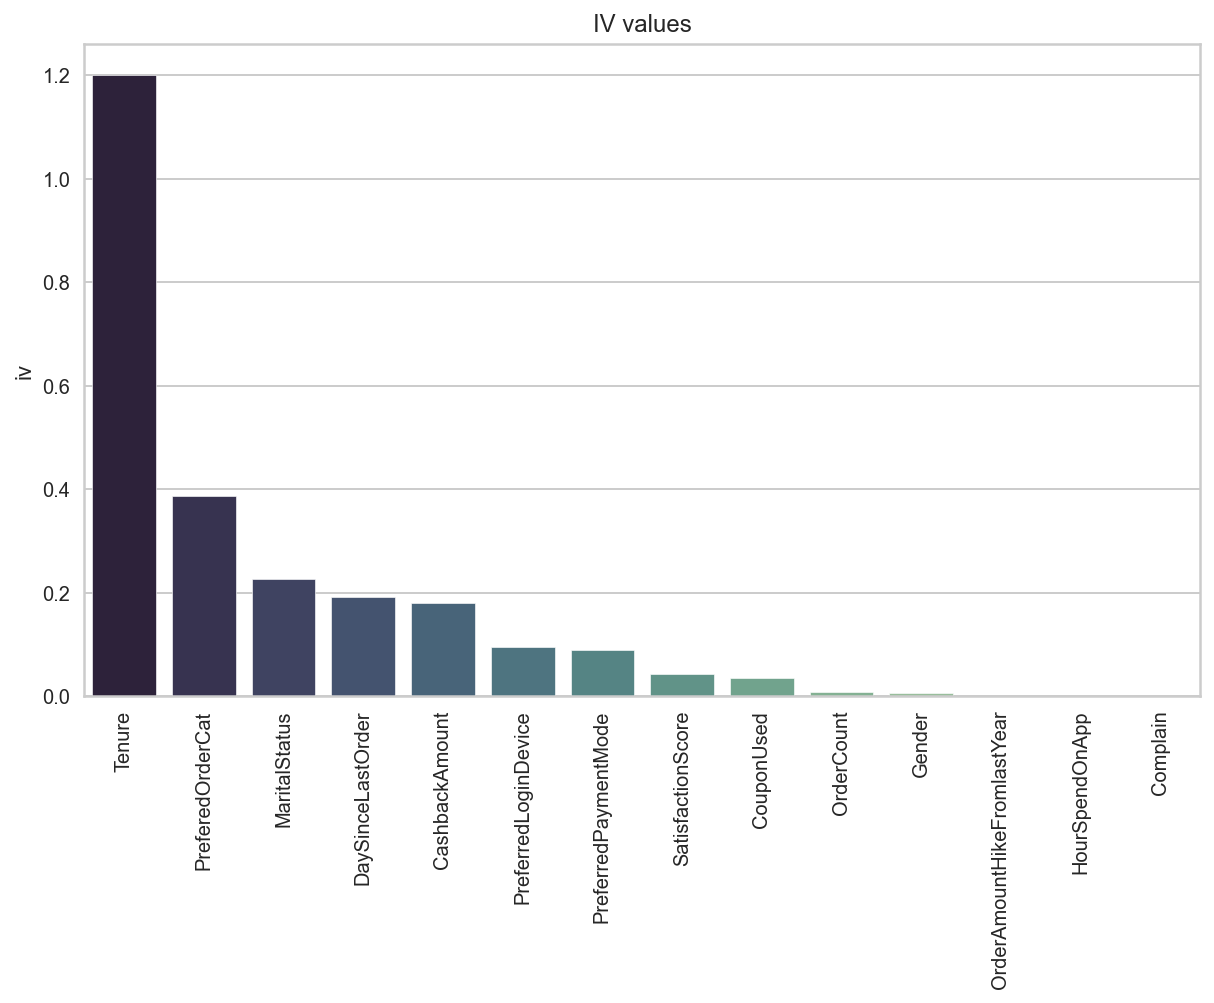

In [26]:
ar.draw_iv(feats, iv)

In [27]:
#seleksi fitur 
feature_keep = df_analysis[df_analysis["iv"] > 0.02].index
feature_keep

Index(['Tenure', 'PreferedOrderCat', 'MaritalStatus', 'DaySinceLastOrder',
       'CashbackAmount', 'PreferredLoginDevice', 'PreferredPaymentMode',
       'SatisfactionScore', 'CouponUsed'],
      dtype='object')

In [28]:
#splitting data 
feature_keep = ['Tenure','PreferedOrderCat','MaritalStatus','DaySinceLastOrder',
                'CashbackAmount','PreferredLoginDevice',
                'PreferredPaymentMode','SatisfactionScore','Churn']

df = df[feature_keep]

df.head()

,Tenure,PreferedOrderCat,MaritalStatus,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,SatisfactionScore,Churn
0,4.0,Laptop & Accessory,Single,5.0,159.93,Mobile Phone,Debit Card,2,1
1,9.0,Mobile,Single,0.0,120.90,Phone,UPI,3,1
2,9.0,Mobile,Single,3.0,120.28,Phone,Debit Card,3,1
3,0.0,Laptop & Accessory,Single,3.0,134.07,Phone,Debit Card,5,1
4,0.0,Mobile,Single,3.0,129.60,Phone,CC,5,1


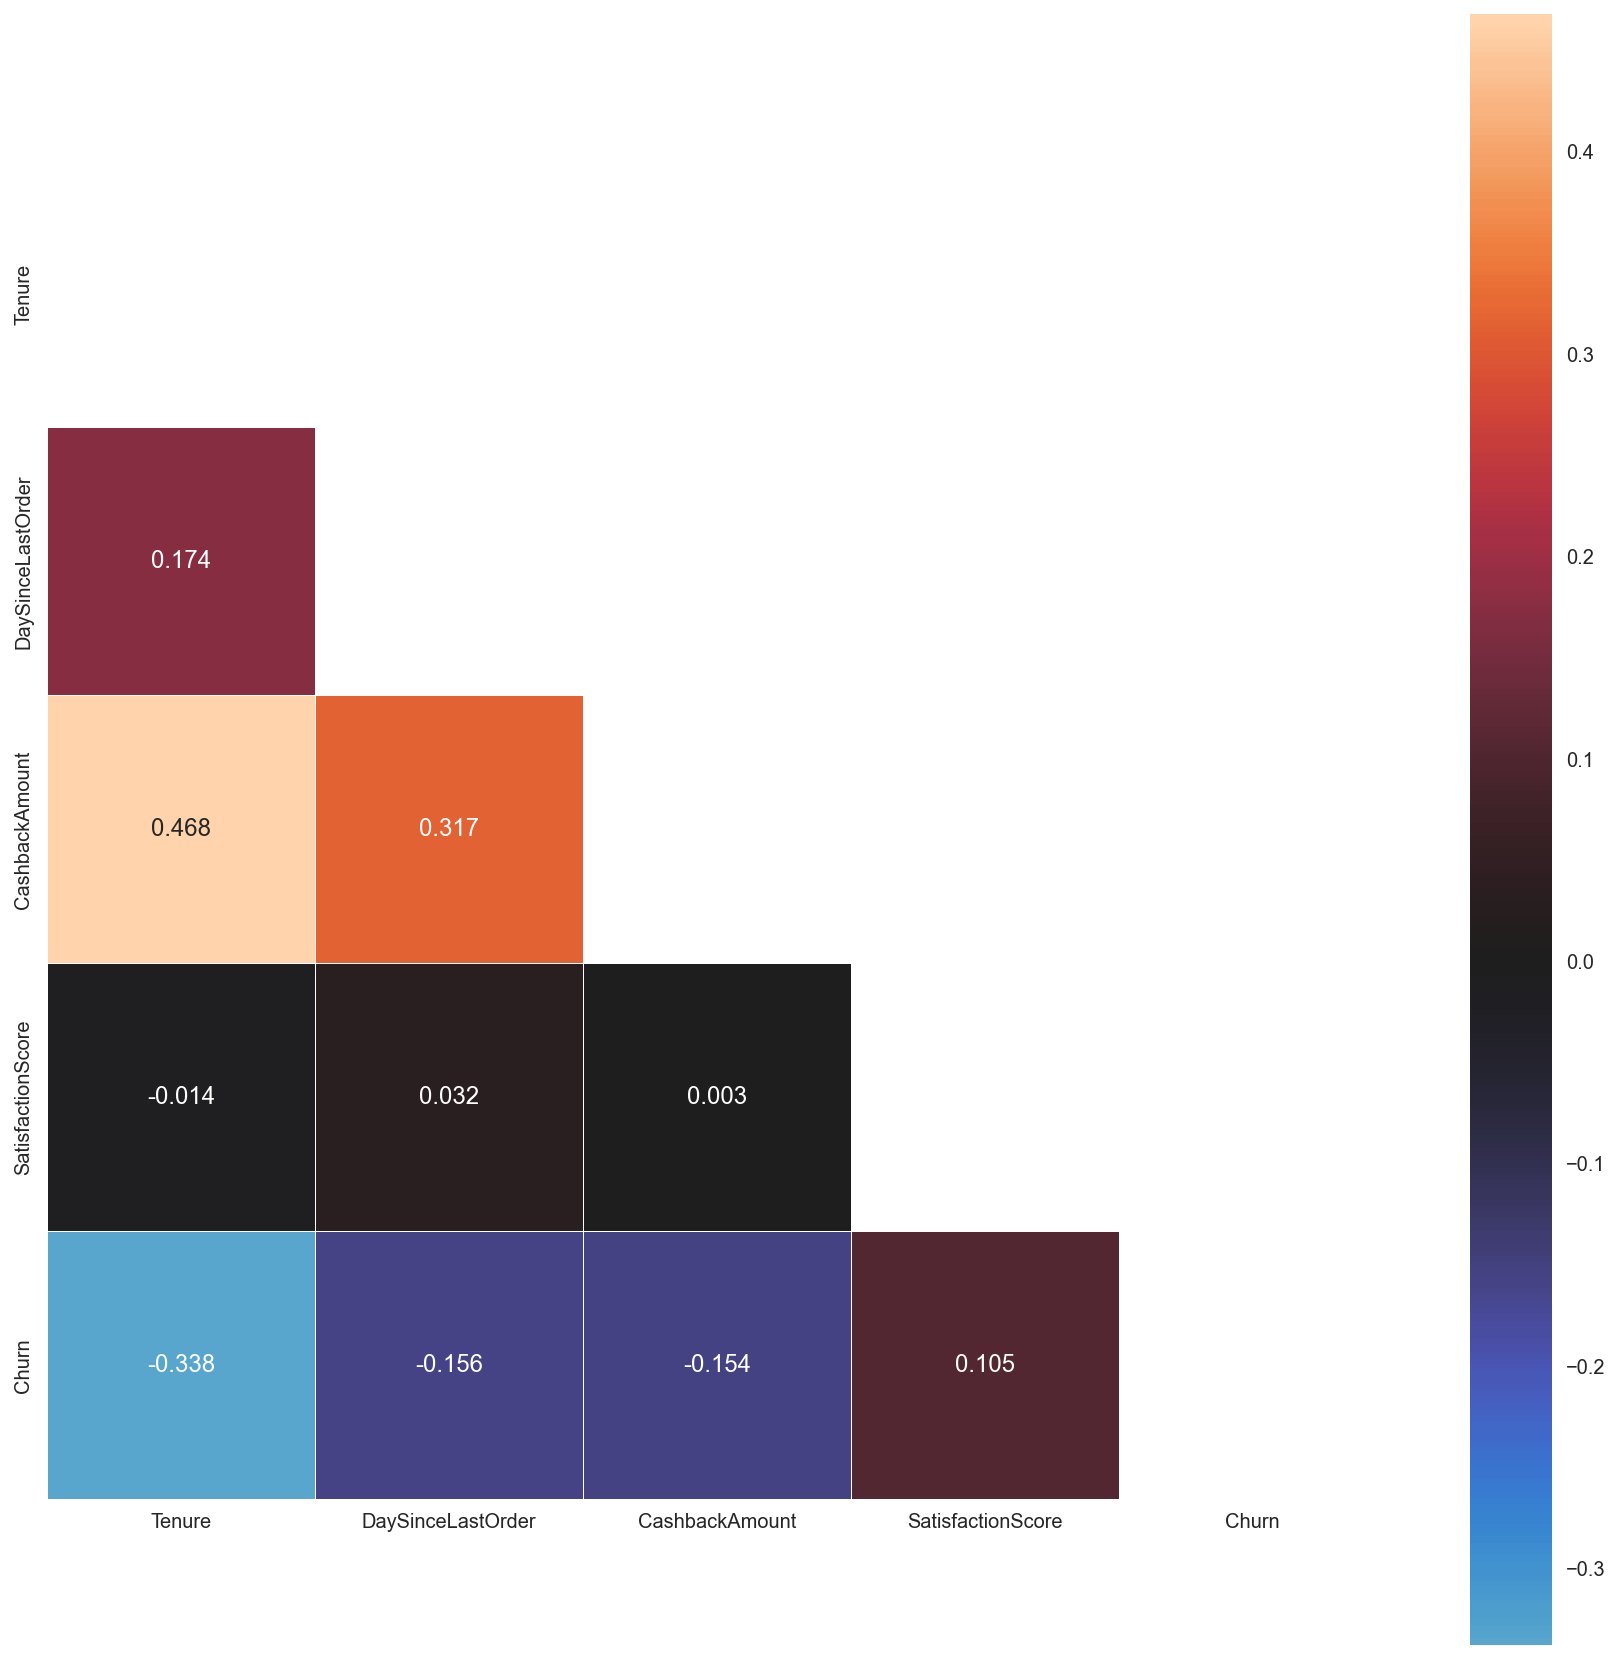

In [29]:
#check korelasi
fig = plt.figure(figsize = (15,15))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), center = 0,
           fmt='.3f', square = True,
           annot = True, linewidth = 0.3, mask = matrix)
plt.show()

C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/1512457655.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(3, len(nums)/2, i+1)
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tengku Muhammad Reza\AppData\Roaming\Python\Python39\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\TENGKU~1\AppData\Local\Temp/ipykernel_9976/1512457655.py:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specifi

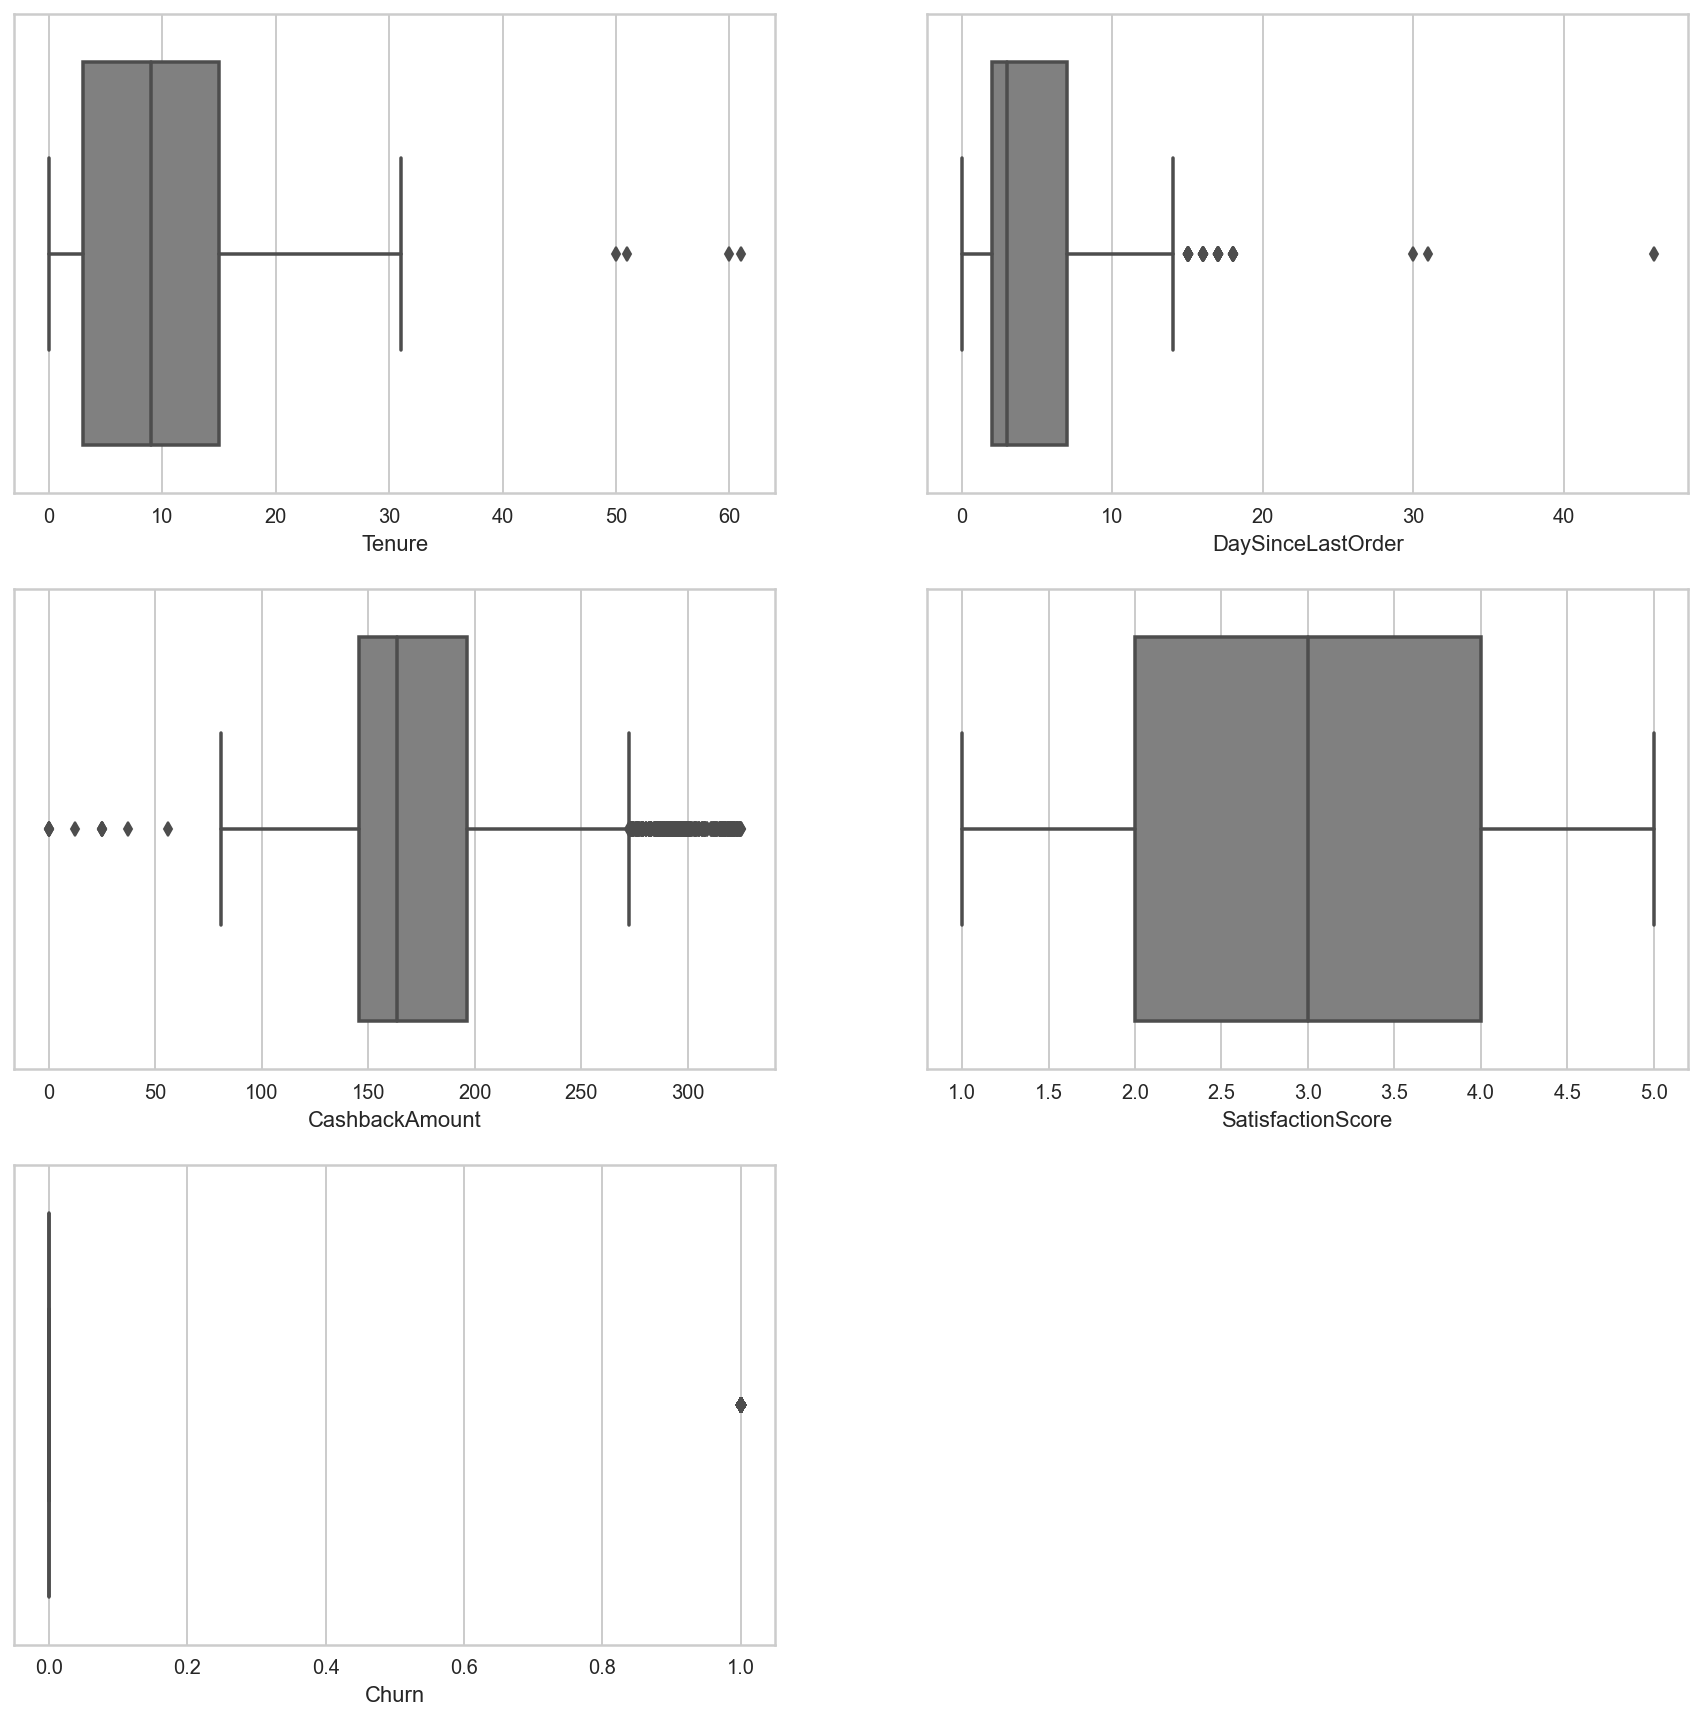

In [30]:
nums = ['Tenure','DaySinceLastOrder','CashbackAmount','SatisfactionScore','Churn']
plt.figure(figsize=(15,15))
for i in range(0, len(nums)):
    plt.subplot(3, len(nums)/2, i+1)
    sns.boxplot(df[nums[i]], color='gray', orient='v')

In [31]:
#handle outliers pada fitur selection(numerical)

print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))
for col in ['Tenure', 'DaySinceLastOrder', 'CashbackAmount']:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    
df = df[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 5630
Jumlah baris setelah memfilter outlier: 5572


In [32]:
df.sample(5)

,Tenure,PreferedOrderCat,MaritalStatus,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,SatisfactionScore,Churn
3901,11.0,Laptop & Accessory,Married,3.0,220.25,Computer,Credit Card,1,0
3927,1.0,Laptop & Accessory,Single,1.0,192.35,Mobile Phone,Debit Card,4,1
4784,27.0,Fashion,Married,5.0,234.34,Mobile Phone,E wallet,1,0
1059,27.0,Grocery,Married,7.0,274.26,Mobile Phone,Credit Card,3,0
5140,1.0,Mobile Phone,Single,1.0,152.85,Computer,Debit Card,1,1


In [33]:
#Cek payment method
df['PreferredPaymentMode'].value_counts()

Debit Card          2290
Credit Card         1487
E wallet             602
UPI                  410
COD                  363
CC                   273
Cash on Delivery     147
Name: PreferredPaymentMode, dtype: int64

In [34]:
#mereplcae CC dan Cash on delivery 
df['PreferredPaymentMode']=df['PreferredPaymentMode'].replace(
    ['Cash on Delivery','CC'],['COD','Credit Card'])

In [35]:
#split data train dan data test 
X = df.drop("Churn",axis=1)
y = df["Churn"]

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 stratify=y,
                                                 test_size=0.3,
                                                 random_state=42)

X_train["Churn"] = y_train


print(f'Ukuran data train { X_train.shape[0]}')
print(f'Ukuran data test {X_test.shape[0]}')

Ukuran data train 3900
Ukuran data test 1672


<AxesSubplot:xlabel='PreferredPaymentMode', ylabel='Count'>

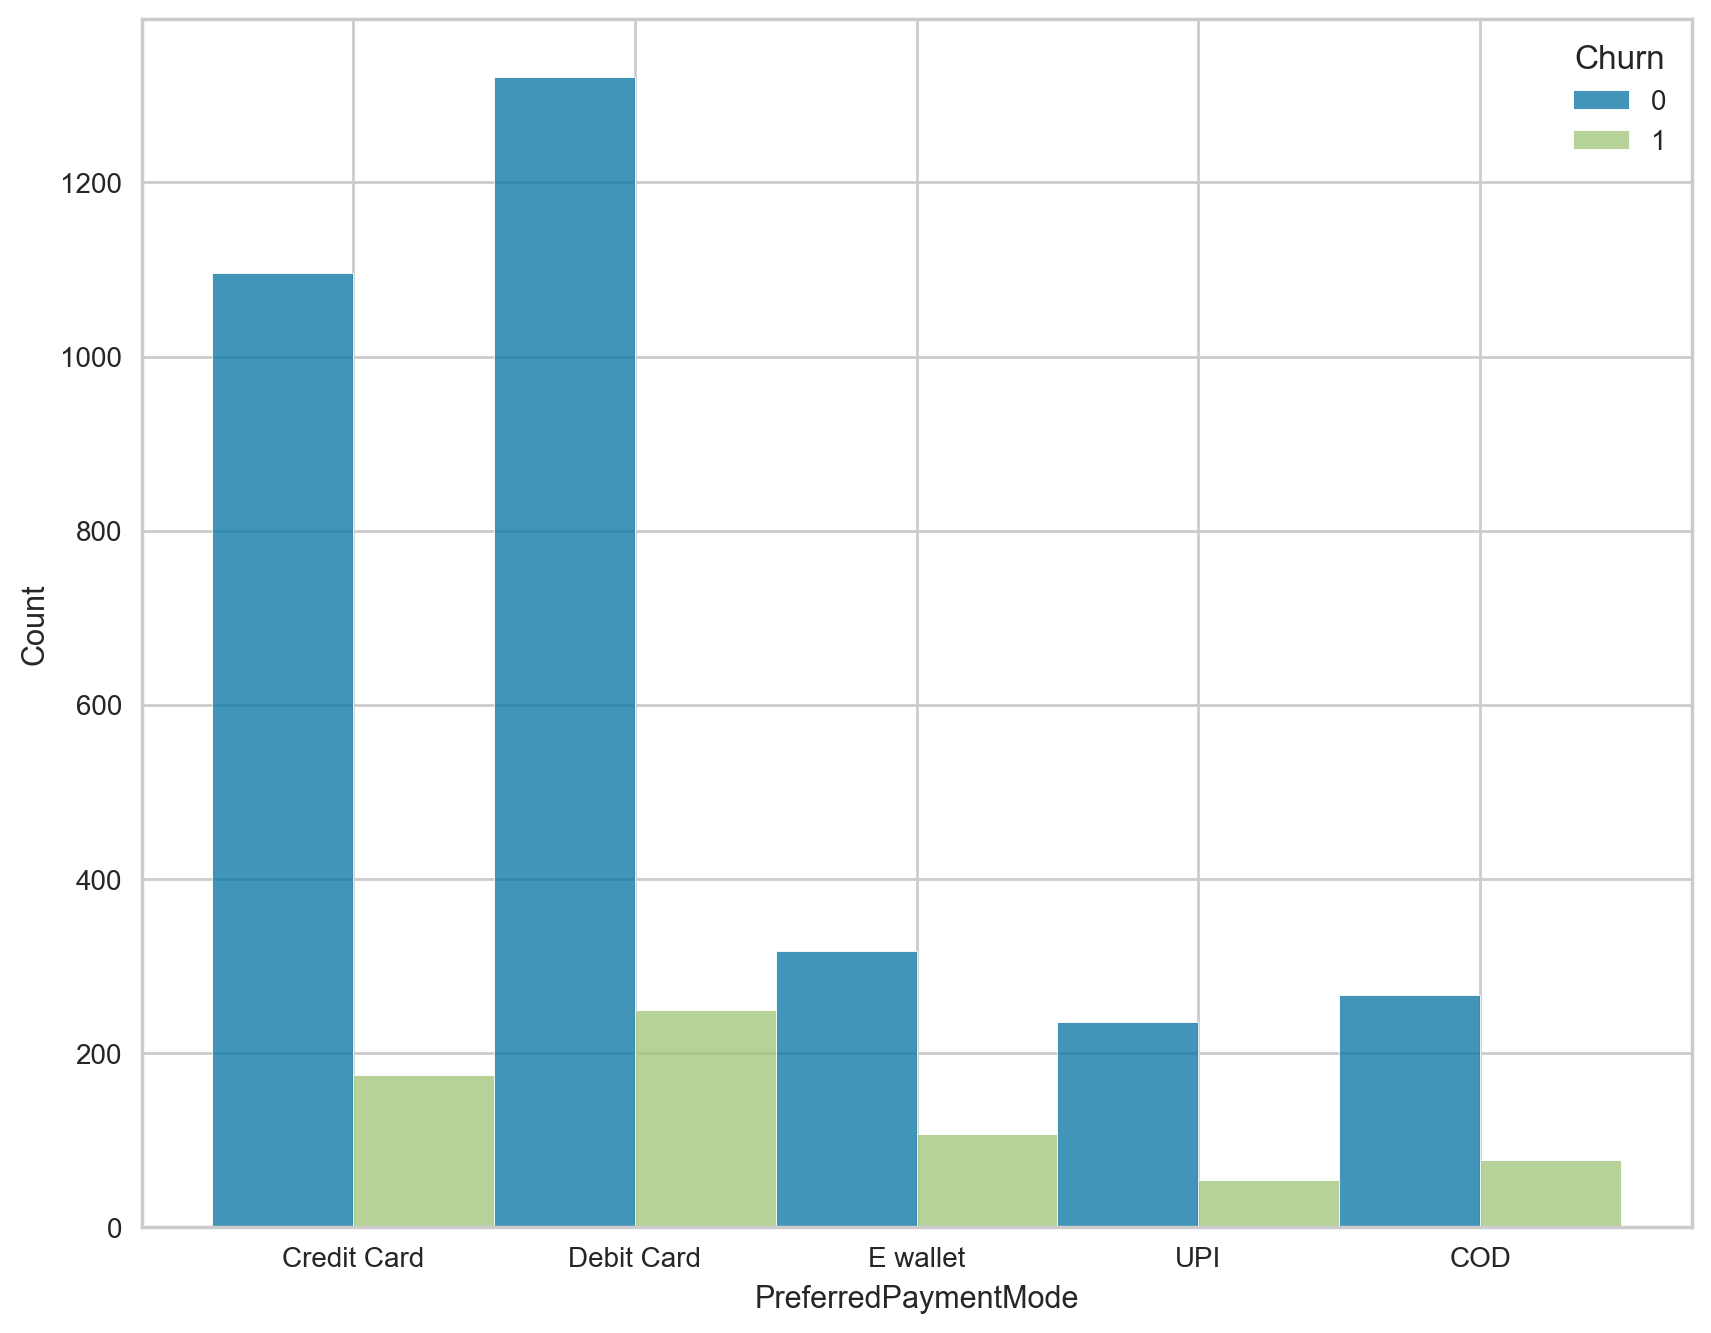

In [36]:
#EDA 
plt.figure(figsize=(10,8),dpi=100)
sns.histplot(data=X_train,x='PreferredPaymentMode',hue='Churn',multiple="dodge")

<AxesSubplot:xlabel='CashbackAmount', ylabel='Count'>

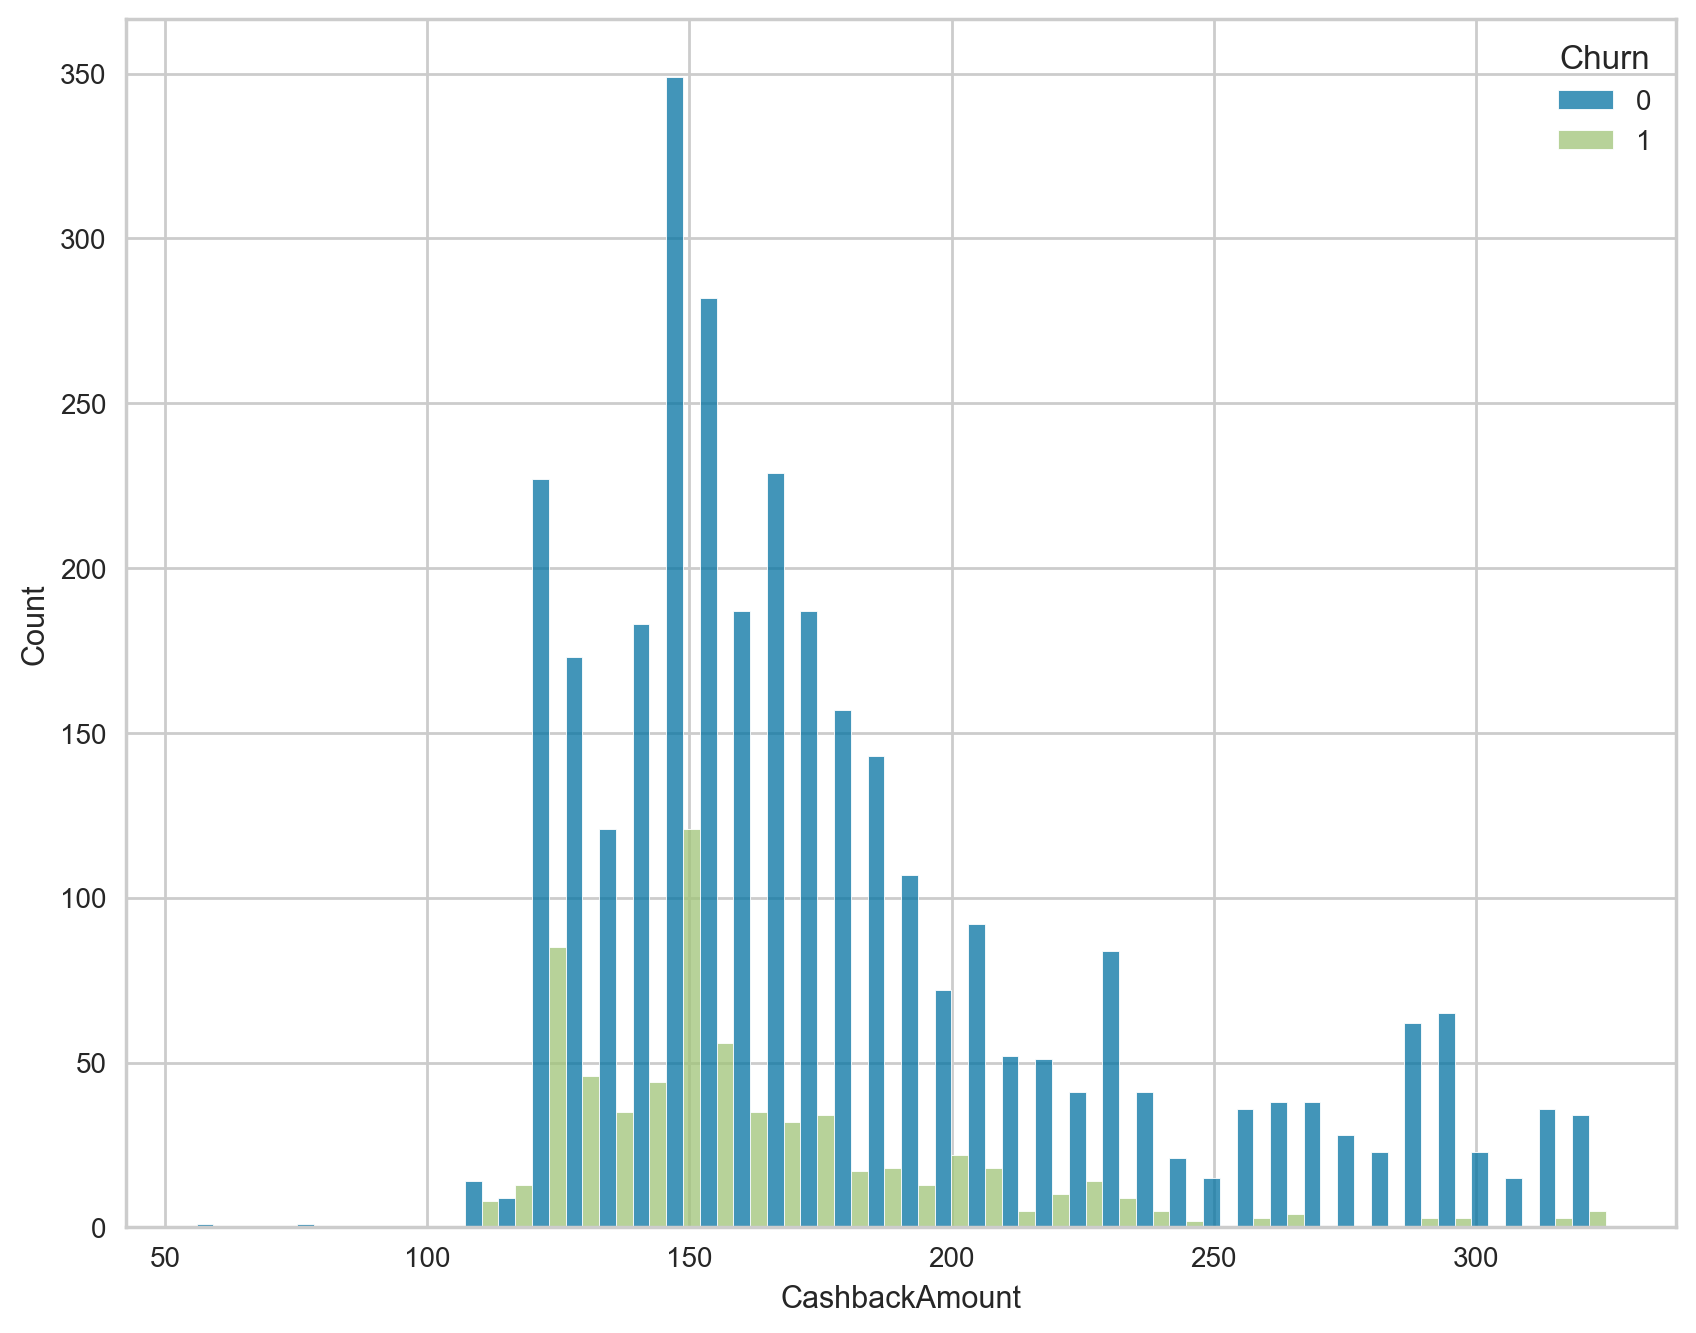

In [37]:
plt.figure(figsize=(10,8),dpi=100)
sns.histplot(data=X_train,x='CashbackAmount',hue='Churn',multiple="dodge")

<AxesSubplot:xlabel='SatisfactionScore', ylabel='Count'>

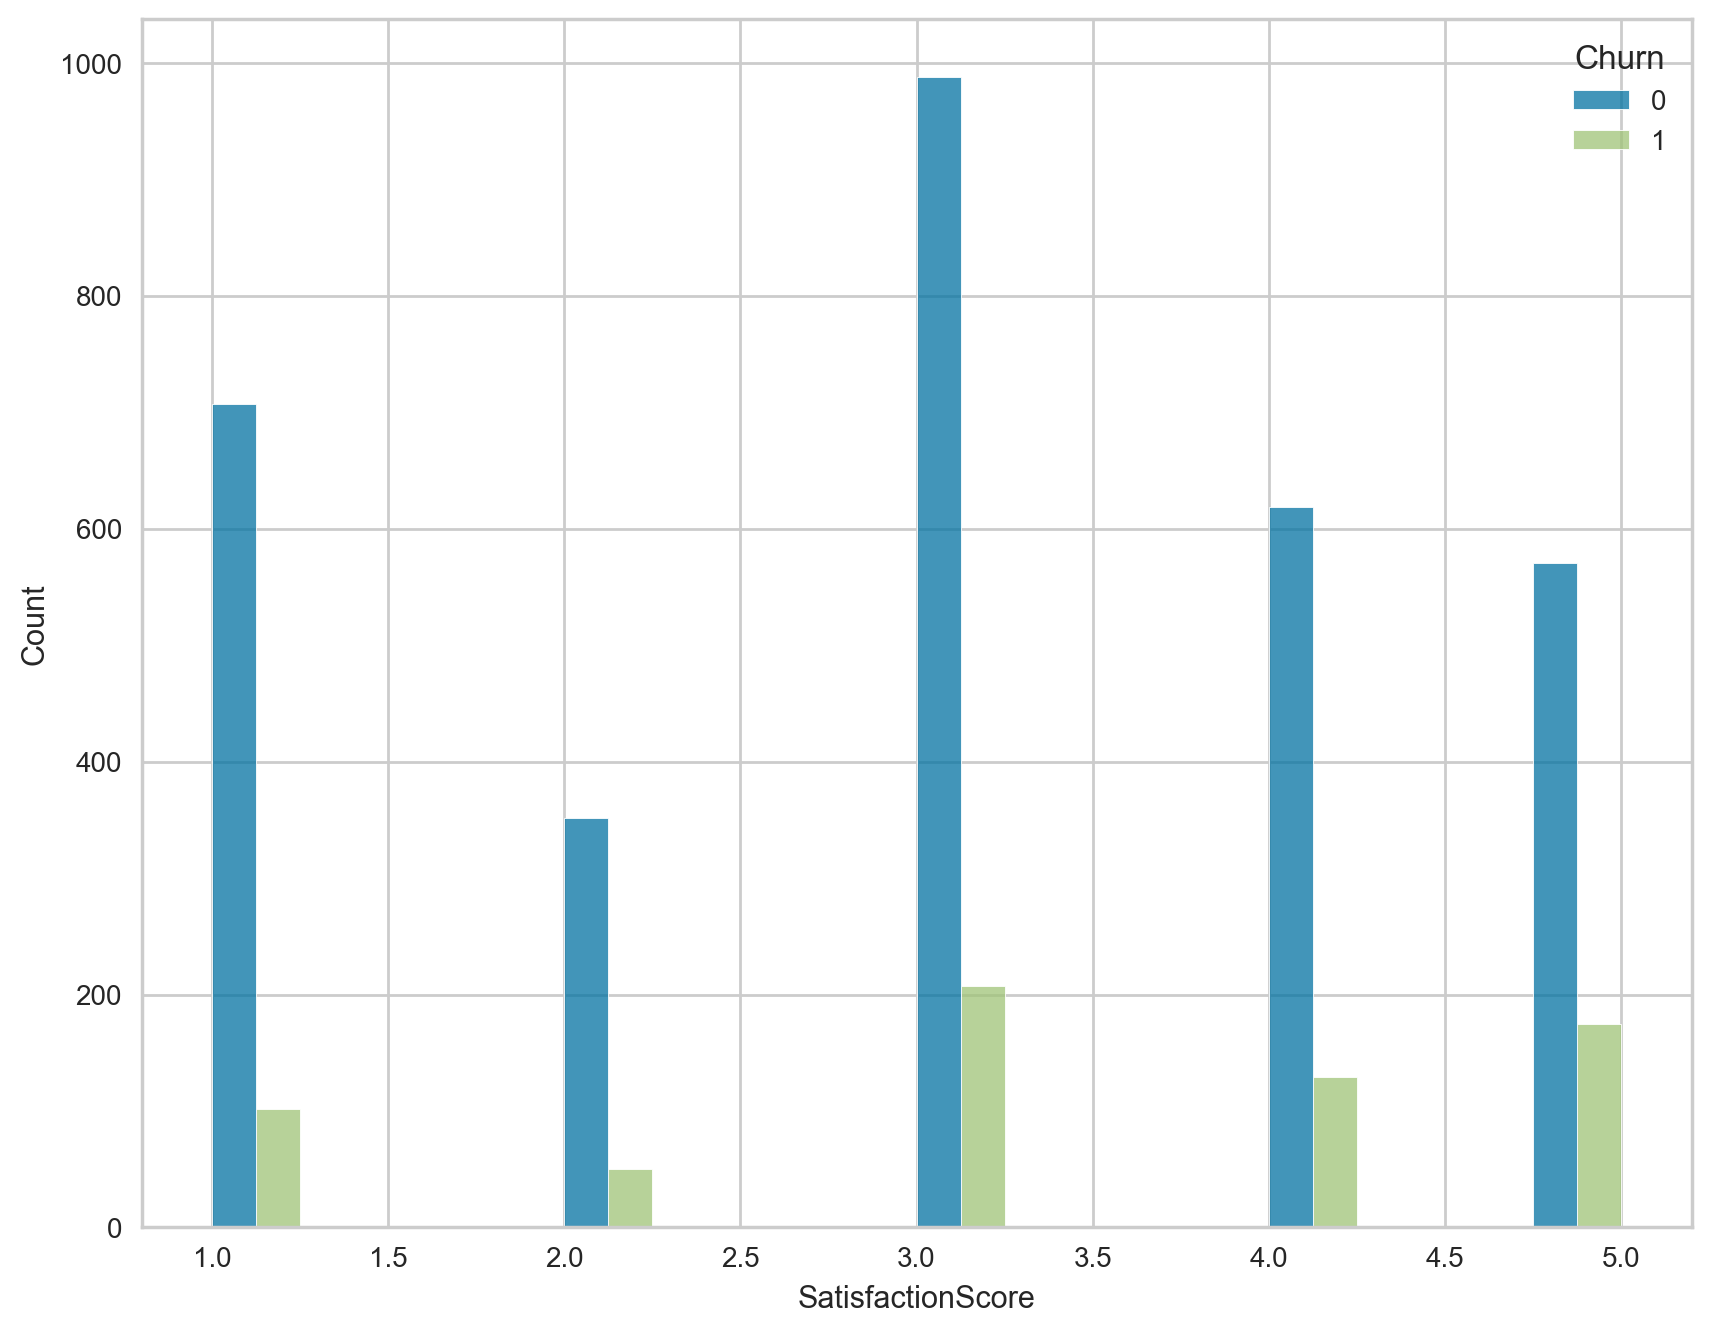

In [38]:
#insight churn dengan satisfication score 
plt.figure(figsize=(10,8),dpi=100)
sns.histplot(data=X_train,x='SatisfactionScore',hue='Churn',multiple="dodge")


In [39]:
X_test["Churn"] = y_test

In [40]:
#categorical handling 
X_train.head()

,Tenure,PreferedOrderCat,MaritalStatus,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,SatisfactionScore,Churn
990,7.0,Mobile,Single,0.0,129.72,Phone,Credit Card,1,0
1353,11.0,Fashion,Single,8.0,195.26,Computer,Debit Card,3,0
3909,3.0,Mobile Phone,Married,3.0,154.74,Mobile Phone,Credit Card,3,0
815,2.0,Mobile Phone,Single,3.0,139.04,Phone,Credit Card,5,1
719,3.0,Laptop & Accessory,Divorced,4.0,165.78,Mobile Phone,E wallet,3,0


In [41]:
print(X_train['PreferedOrderCat'].unique())
print(X_train['MaritalStatus'].unique())
print(X_train['PreferredLoginDevice'].unique())#nominal bukan ordinal
print(X_train['PreferredPaymentMode'].unique())
#category pakai one hot encoding

['Mobile' 'Fashion' 'Mobile Phone' 'Laptop & Accessory' 'Grocery' 'Others']
['Single' 'Married' 'Divorced']
['Phone' 'Computer' 'Mobile Phone']
['Credit Card' 'Debit Card' 'E wallet' 'UPI' 'COD']


In [42]:
#mengubah x_train
X_train['PreferedOrderCat'] = X_train['PreferedOrderCat'].replace(
    ['Mobile','Fashion','Mobile Phone','Laptop & Accessory','Grocery','Others'],
    [i for i in range(0,6)])
X_train['MaritalStatus']= X_train['MaritalStatus'].replace(
    ['Single','Married','Divorced'],[0,1,2])
X_train['PreferredLoginDevice']=X_train['PreferredLoginDevice'].replace(
    ['Phone','Computer','Mobile Phone'],[0,1,2])
X_train['PreferredPaymentMode'] = X_train['PreferredPaymentMode'].replace(
    ['Credit Card','Debit Card','E wallet','UPI','COD'],[i for i in range(0,5)])



In [43]:
X_train.head()

,Tenure,PreferedOrderCat,MaritalStatus,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,SatisfactionScore,Churn
990,7.0,0,0,0.0,129.72,0,0,1,0
1353,11.0,1,0,8.0,195.26,1,1,3,0
3909,3.0,2,1,3.0,154.74,2,0,3,0
815,2.0,2,0,3.0,139.04,0,0,5,1
719,3.0,3,2,4.0,165.78,2,2,3,0


In [44]:
#mengubah x_test 
X_test['PreferedOrderCat'] = X_test['PreferedOrderCat'].replace(
    ['Mobile','Fashion','Mobile Phone','Laptop & Accessory','Grocery','Others'],
    [i for i in range(0,6)])
X_test['MaritalStatus']= X_test['MaritalStatus'].replace(
    ['Single','Married','Divorced'],[0,1,2])
X_test['PreferredLoginDevice']=X_test['PreferredLoginDevice'].replace(
    ['Phone','Computer','Mobile Phone'],[0,1,2])
X_test['PreferredPaymentMode'] = X_test['PreferredPaymentMode'].replace(
    ['Credit Card','Debit Card','E wallet','UPI','COD'],[i for i in range(0,5)])


In [45]:
X_test.head()

,Tenure,PreferedOrderCat,MaritalStatus,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,SatisfactionScore,Churn
5558,7.0,3,1,9.0,184.68,1,1,3,0
3207,1.0,3,2,3.0,173.51,2,1,4,0
1401,8.0,1,1,8.0,190.69,1,1,5,0
3542,3.0,2,2,9.0,156.31,2,0,2,0
1707,0.0,0,0,2.0,126.10,1,0,1,0


In [46]:
#scalling fitur 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[X_train.columns]=scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns]=scaler.transform(X_test[X_test.columns])

In [47]:
X_train.head()

,Tenure,PreferedOrderCat,MaritalStatus,DaySinceLastOrder,CashbackAmount,PreferredLoginDevice,PreferredPaymentMode,SatisfactionScore,Churn
990,-0.370682,-1.660058,-1.254618,-1.304319,-0.979422,-1.602845,-0.980777,-1.497181,-0.452570
1353,0.113545,-0.908987,-1.254618,1.096410,0.359548,-0.342797,-0.160835,-0.041070,-0.452570
3909,-0.854910,-0.157917,0.256037,-0.404046,-0.468268,0.917250,-0.980777,-0.041070,-0.452570
815,-0.975967,-0.157917,-1.254618,-0.404046,-0.789016,-1.602845,-0.980777,1.415041,2.209605
719,-0.854910,0.593153,1.766691,-0.103955,-0.242723,0.917250,0.659107,-0.041070,-0.452570


In [48]:
#membuat model logistic regression 
def evaluation_train(X,y,model):
    model.fit(X,y)
    predict = model.predict(X)
    cm = confusion_matrix(y, predict, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=model.classes_)
    
    print(f"Recall Score {model} {recall_score(y,predict)}")
    print(f'precission Score {model} {precision_score(y,predict)}')
    print(f'F1 Score {model} {f1_score(y,predict)}')
    print(f'ROC-Auc Score {model} {roc_auc_score(y,predict)}')
    
    disp.plot()
    
def evaluation_test(X,y,model):
    predict = model.predict(X)
    cm = confusion_matrix(y, predict, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=model.classes_)
    
    print(f"Recall Score {model} {recall_score(y,predict)}")
    print(f'precission Score {model} {precision_score(y,predict)}')
    print(f'F1 Score {model} {f1_score(y,predict)}')
    print(f'ROC-Auc Score {model} {roc_auc_score(y,predict)}')
    
    disp.plot()

#konfusion matrix fokus pada satu matrix
#churn = false negatif(recall)

Recall Score LogisticRegression(random_state=42) 1.0
precission Score LogisticRegression(random_state=42) 1.0
F1 Score LogisticRegression(random_state=42) 1.0
ROC-Auc Score LogisticRegression(random_state=42) 1.0


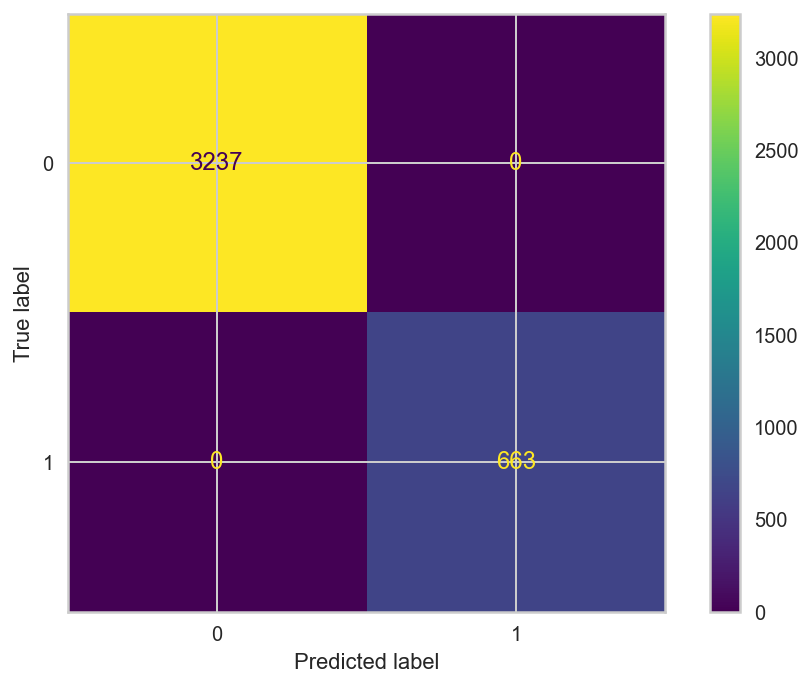

In [49]:
#logreg data train
logreg = LogisticRegression(random_state=42)
evaluation_train(X_train,y_train,logreg)


Recall Score LogisticRegression(random_state=42) 1.0
precission Score LogisticRegression(random_state=42) 1.0
F1 Score LogisticRegression(random_state=42) 1.0
ROC-Auc Score LogisticRegression(random_state=42) 1.0


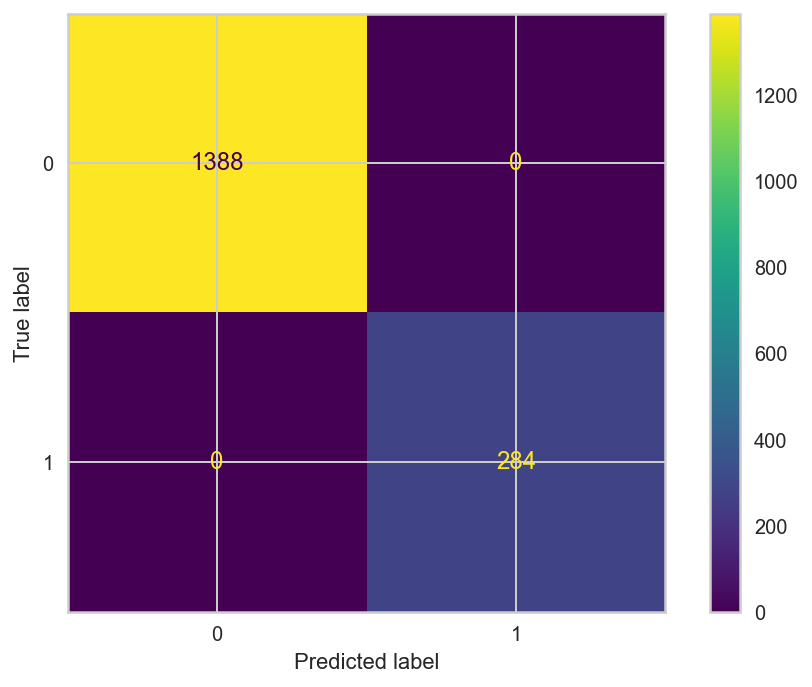

In [50]:
#logreg data test 
evaluation_train(X_test,y_test,logreg)

Recall Score KNeighborsClassifier() 1.0
precission Score KNeighborsClassifier() 1.0
F1 Score KNeighborsClassifier() 1.0
ROC-Auc Score KNeighborsClassifier() 1.0


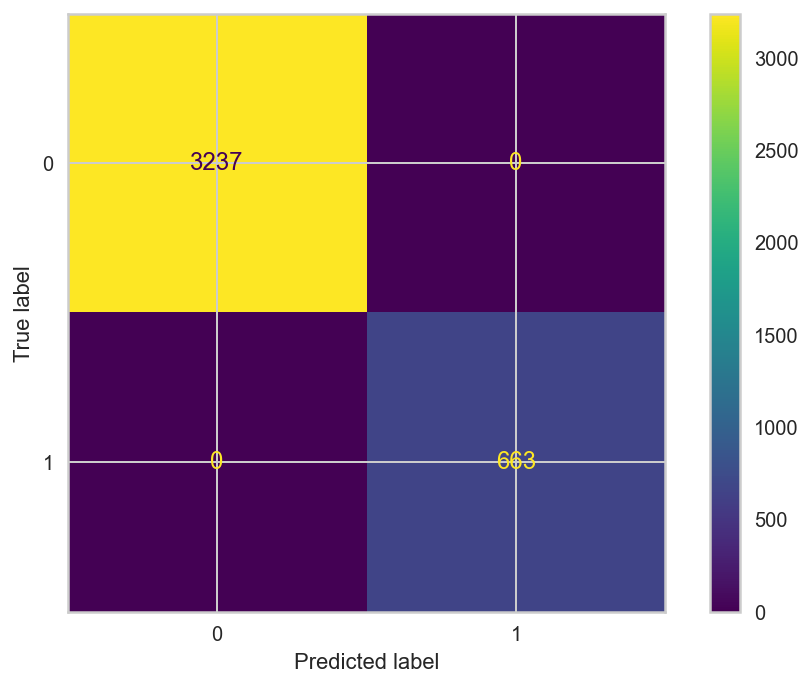

In [51]:
#KNN Model data train 
knn_model = KNeighborsClassifier()
evaluation_train(X_train,y_train,knn_model)

Recall Score KNeighborsClassifier() 0.9964788732394366
precission Score KNeighborsClassifier() 1.0
F1 Score KNeighborsClassifier() 0.998236331569665
ROC-Auc Score KNeighborsClassifier() 0.9982394366197183


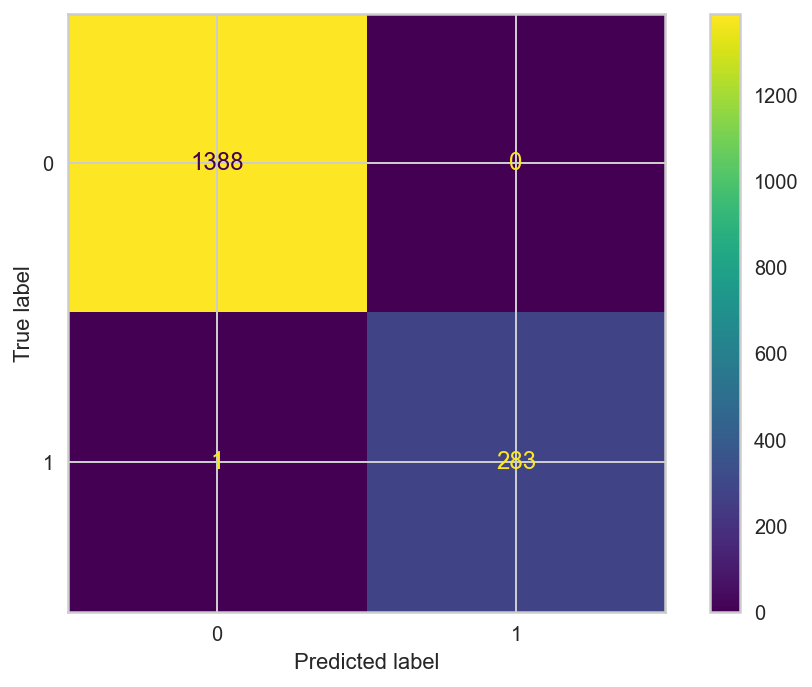

In [52]:
#KNN data test 
evaluation_train(X_test,y_test,knn_model)

In [53]:
#SVM data train 
svc = SVC(random_state=42,kernel="rbf")

Recall Score SVC(random_state=42) 1.0
precission Score SVC(random_state=42) 1.0
F1 Score SVC(random_state=42) 1.0
ROC-Auc Score SVC(random_state=42) 1.0


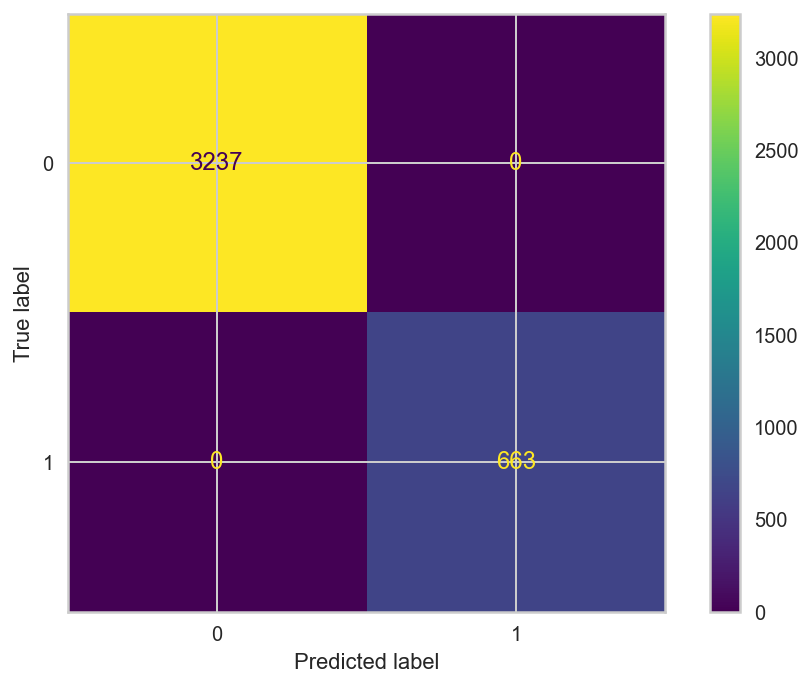

In [54]:
evaluation_train(X_train,y_train,svc)

Recall Score SVC(random_state=42) 1.0
precission Score SVC(random_state=42) 1.0
F1 Score SVC(random_state=42) 1.0
ROC-Auc Score SVC(random_state=42) 1.0


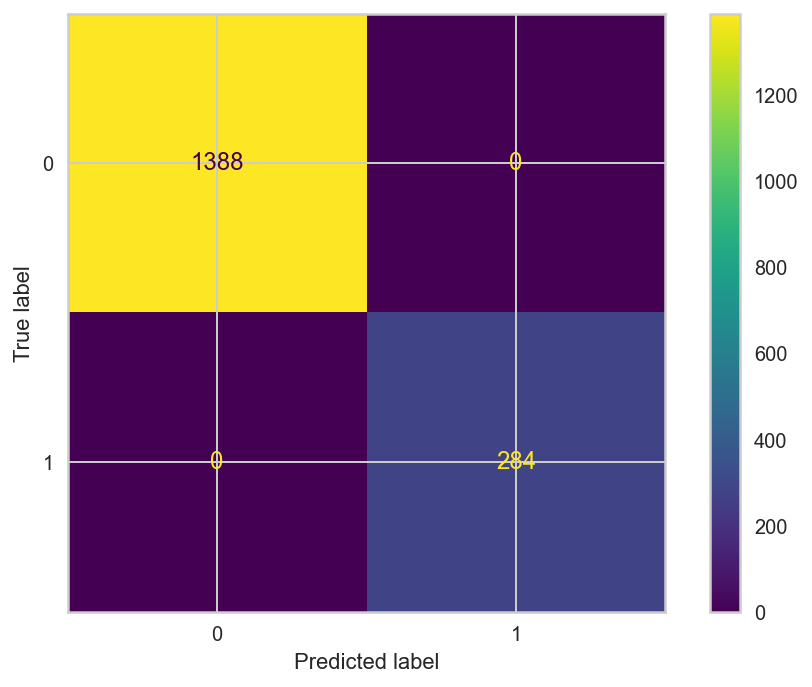

In [55]:
#data test 
evaluation_train(X_test,y_test,svc)

In [56]:
#Decission tree data train 
dt = DecisionTreeClassifier(random_state=42)


Recall Score DecisionTreeClassifier(random_state=42) 1.0
precission Score DecisionTreeClassifier(random_state=42) 1.0
F1 Score DecisionTreeClassifier(random_state=42) 1.0
ROC-Auc Score DecisionTreeClassifier(random_state=42) 1.0


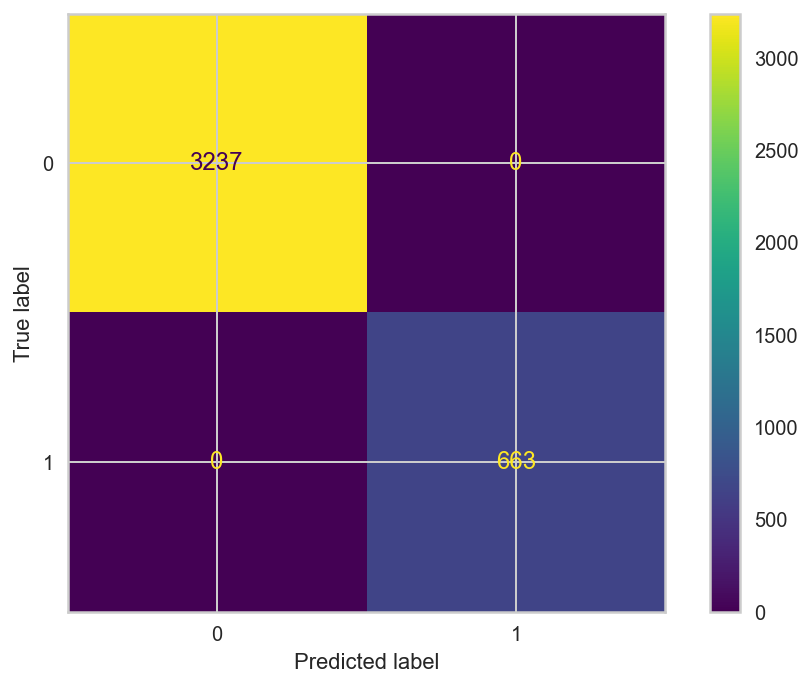

In [57]:
evaluation_train(X_train,y_train,dt)

Recall Score DecisionTreeClassifier(random_state=42) 1.0
precission Score DecisionTreeClassifier(random_state=42) 1.0
F1 Score DecisionTreeClassifier(random_state=42) 1.0
ROC-Auc Score DecisionTreeClassifier(random_state=42) 1.0


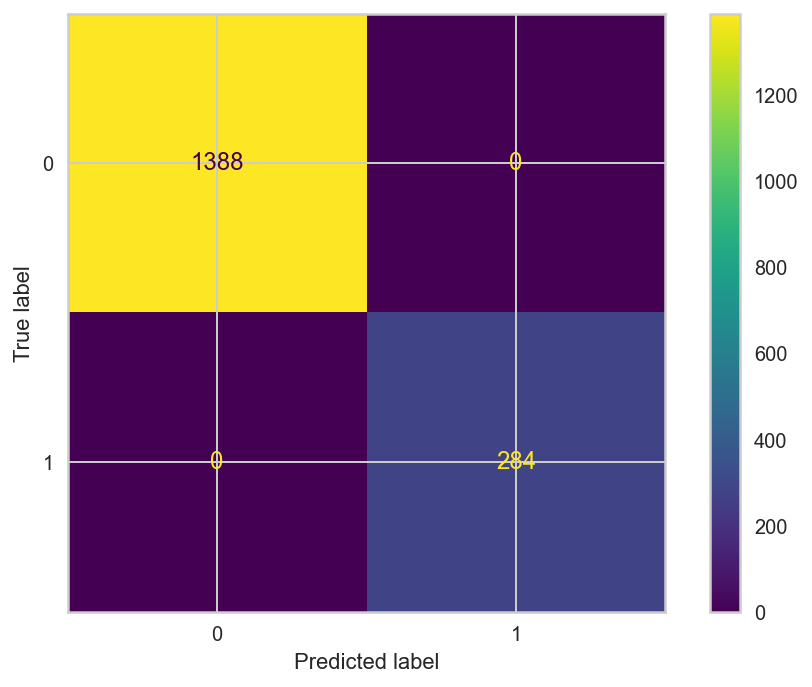

In [58]:
#data test 
evaluation_test(X_test,y_test,dt)

In [59]:
#random forest 
rf = RandomForestClassifier(random_state=42)

Recall Score RandomForestClassifier(random_state=42) 1.0
precission Score RandomForestClassifier(random_state=42) 1.0
F1 Score RandomForestClassifier(random_state=42) 1.0
ROC-Auc Score RandomForestClassifier(random_state=42) 1.0


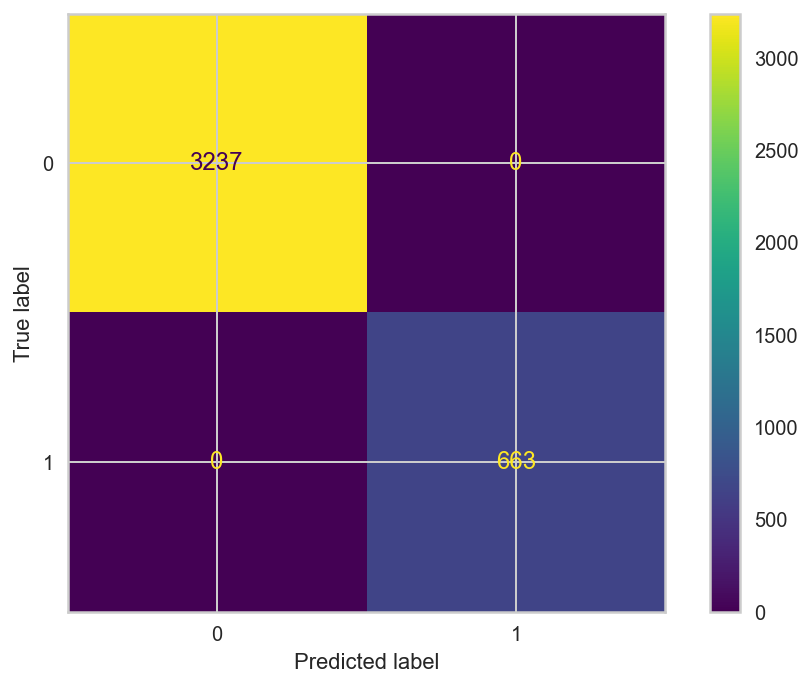

In [60]:
evaluation_train(X_train,y_train,rf)

Recall Score RandomForestClassifier(random_state=42) 1.0
precission Score RandomForestClassifier(random_state=42) 1.0
F1 Score RandomForestClassifier(random_state=42) 1.0
ROC-Auc Score RandomForestClassifier(random_state=42) 1.0


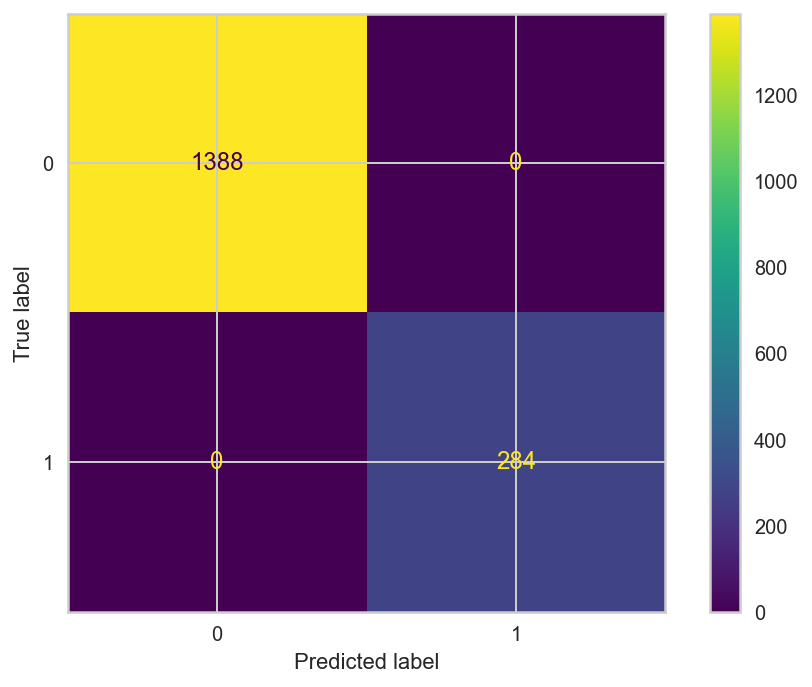

In [61]:
#data test 
evaluation_test(X_test,y_test,rf)

In [62]:
#XGboost data train 
xgb_cl =  XGBClassifier(radom_state=42)

[05:39:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "radom_state" } are not used.

Recall Score XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, radom_state=42, ...) 1.0
precission Score XGBClassifier(base_score=None, booster=None, callbacks=None,
           

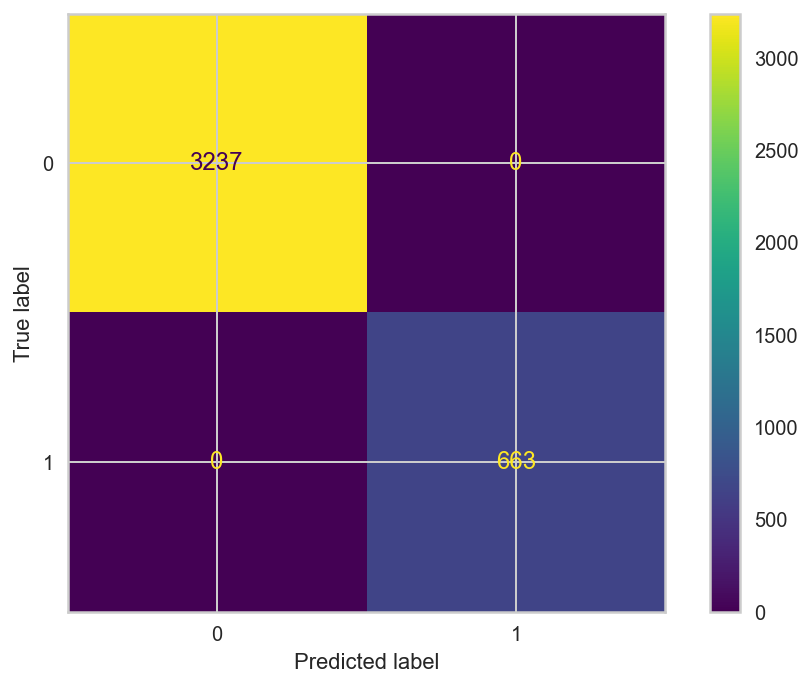

In [63]:
evaluation_train(X_train,y_train,xgb_cl)

Recall Score XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, radom_state=42, ...) 1.0
precission Score XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categoric

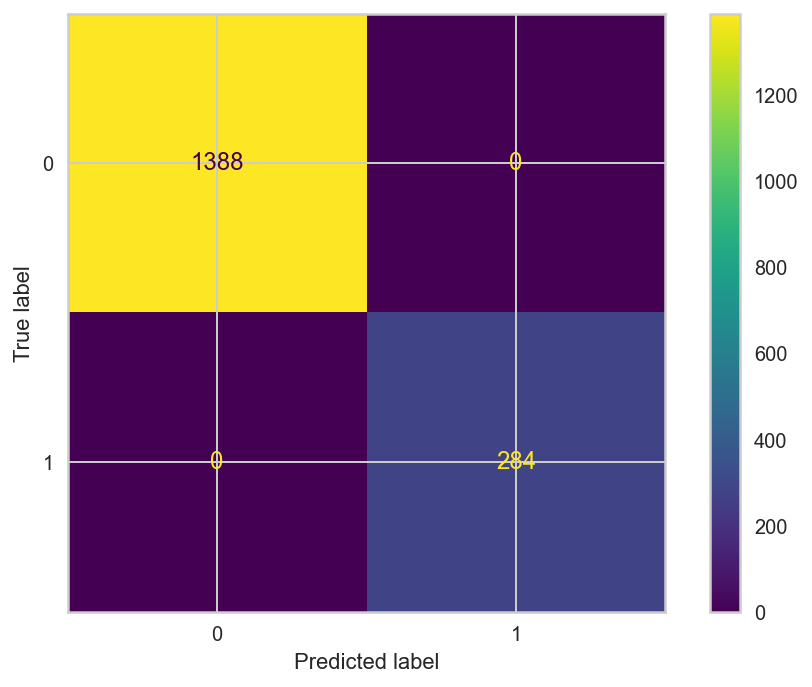

In [64]:
#data test
evaluation_test(X_test,y_test,xgb_cl)